Lines in use:  {'l1': (1, 2, 9, 0.5, 2, (1.0, 1.0), 1.41), 'l2': (2, 1, 9.25, 0.5, 2, (2.0, 2.0), 1.41), 'l3': (3, 4, 9.4, 0.5, 1, (2.2, 2.0), 1.0), 'l4': (4, 3, 9.65, 0.5, 1, (2.2, 1.0), 1.0)}
----------------------------------------------------------------------------------------------------
Operation time range:  9.9 - 11.6
----------------------------------------------------------------------------------------------------
Number of trips:  6
----------------------------------------------------------------------------------------------------
Trips: 
['l1', 10.0, 10.5, 1.41]
['l2', 10.25, 10.75, 1.41]
['l3', 10.4, 10.9, 1.0]
['l1', 10.5, 11.0, 1.41]
['l2', 10.75, 11.25, 1.41]
['l1', 11.0, 11.5, 1.41]
----------------------------------------------------------------------------------------------------
Pairwise station switch times: 
(2, [(1, 0.14), (4, 0.16), (3, 0.12)])
(1, [(2, 0.14), (4, 0.02), (3, 0.1)])
(4, [(2, 0.16), (1, 0.02), (3, 0.1)])
(3, [(2, 0.12), (1, 0.1), (4, 0.1)])
---

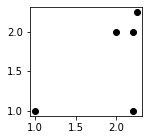

In [1]:
import math
from itertools import combinations
from copy import deepcopy
import matplotlib.pyplot as plt

'''
TESTING FOR 9-12
Assign distance/time based on path length
'''

lines = {'l1' :(1, 2, 9, 0.5, 2, (1.0, 1.0), 1.41), 'l2': (2, 1, 9.25, 0.5, 2, (2.0, 2.0), 1.41), 'l3': (3, 4, 9.4, 0.5, 1, (2.2, 2.0), 1.0), 'l4': (4, 3, 9.65, 0.5, 1, (2.2, 1.0), 1.0)}

def create_trips(start, end, line_pool = {}):
    num_trips = 0
    trips = []
    latest = 0
    for line in line_pool.keys():
        num_trips_line = 0
        if start <= line_pool[line][2]:
            earliest = line_pool[line][2]
        else:
            earliest = line_pool[line][2] + math.ceil((start - line_pool[line][2]) * line_pool[line][4])/line_pool[line][4]
        latest = round(earliest + 1/line_pool[line][4],2)
        while latest <= end:
            num_trips += 1
            trips.append([line, earliest, earliest + line_pool[line][3], lines[line][6]])
            earliest = latest
            latest = earliest + line_pool[line][3]       
    return sorted(trips, key=lambda y: y[1])

'''
OPTIMIZATION
'''
def station_dist(line_pool = {}):
    dists = {}
    stations = []
    for line in line_pool.values():
        if line[2] not in stations:
            stations.append((line[1], line[5]))

    for s1, s2 in combinations(stations, 2):
        if s1[0] not in dists.keys():
            dists[s1[0]] = [(s2[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0) / 10, 2))]
        else:
            dists[s1[0]].append((s2[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0) / 10, 2)))
        if s2[0] not in dists.keys():
            dists[s2[0]] = [(s1[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0) / 10, 2))]
        else:
            dists[s2[0]].append((s1[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0) / 10, 2)))

    return dists

def possible_swap(end_st, stop_dist):
#     print(stop_dist[end_st])
    next_st = stop_dist[end_st]
    next_st.sort(key = lambda tup: tup[1])
#     print(temp)
#     next_st = [node[0] for node in temp]
# #     print(next_st)
    return next_st

'''
Delete nodes in next_st that belong to the same line
'''

def new_stop(line_pool, trips, buses, cov):
    lines = deepcopy(line_pool)
    rem_trips = []
    for bus in buses.keys():
        if trips == []:
            for i in range(len(buses)):
                if buses[i+1] == []:
                    del buses[i+1]
            return (buses, cov)
            break
        if buses[bus] == []:
            buses[bus] = [trips[0]]
            curr_stop = lines[trips[0][0]][1]
            trips.pop(0)
            cov += 1
        for t in trips:
            trav = buses[bus][-1][-1]
            curr_time = buses[bus][-1][2]
            curr_stop = lines[buses[bus][-1][0]][1]
            for st in possible_swap(curr_stop, stop_dist):
                if st[1] <= t[1] - curr_time:
                    if curr_stop == lines[t[0]][0]:
                        rem_trips.append(t)
                        t[-1] = round(trav-t[-1],2)
                        buses[bus].append(t)
                        cov += 1
                        break
        for t in rem_trips:
            if t in trips:
                trips.remove(t)

    return (buses, cov)

temp = deepcopy(lines)
# del temp['l3']
# del temp['l4']

op_start = 9.9
op_end = 11.6

print('Lines in use: ', temp)
print('-'*100)

print('Operation time range: ', op_start, '-', op_end)
print('-'*100)

trips = create_trips(op_start, op_end, temp)
rem_trips = len(trips)

print('Number of trips: ', rem_trips)
print('-'*100)

print('Trips: ')
for t in trips:
    print(t)
print('-'*100)

print('Pairwise station switch times: ')
stop_dist = station_dist(temp)
for d in stop_dist.items():
    print(d)
next_st = possible_swap(1, stop_dist)
print('-'*100)

buses = {}
ctr = 0
b_range = 4.0

for i in range(rem_trips):
    buses[i+1] = []

while ctr < rem_trips:
    if buses[1] == []:
        buses[ctr+1] = [trips[0]]
        buses[ctr+1][-1][-1] = b_range - trips[0][-1]
#         curr_stop = lines[trips[0][0]][1]
        trips.pop(0)
        ctr += 1
    else:
        buses, ctr = new_stop(lines, trips, buses, ctr)

print('Bus schedule: ')
for bus in buses.items():
    print(bus)
print('-'*100)

stop_coor_x = [2.25]
stop_coor_y = [2.25]

print('Line length: ')
for l in lines.keys():
    stop_coor_x.append(lines[l][5][0])
    stop_coor_y.append(lines[l][5][1])
    print(l, lines[l][6])


plt.figure(figsize=(2,2))
plt.scatter(stop_coor_x, stop_coor_y, c='#000000', alpha = 1.0)


# bus_schedule = deepcopy(buses)
depot_node = (2.25, 2.25)
# def new_schedule(bus_sch):

In [2]:
from copy import deepcopy

def create_trips(start, end, line_pool = {}):
    num_trips = 0
    trips = []
    latest = 0
    for line in line_pool.keys():
        num_trips_line = 0
        if start <= line_pool[line][2]:
            earliest = line_pool[line][2]
        else:
            earliest = line_pool[line][2] + math.ceil((start - line_pool[line][2]) * line_pool[line][4])/line_pool[line][4]
        latest = round(earliest + 1/line_pool[line][4],2)
        while latest <= end:
            num_trips += 1
            trips.append([line, earliest, earliest + line_pool[line][3], lines[line][6]])
            earliest = latest
            latest = earliest + line_pool[line][3]       
    return sorted(trips, key=lambda y: y[1])

def station_dist(line_pool = {}, depot = None):
    dists = {}
    stations = [depot]
    for line in line_pool.values():
        if line[0] not in stations:
            stations.append([line[0], line[5]])
    for s1, s2 in combinations(stations, 2):
        if s1[0] not in dists.keys():
            dists[s1[0]] = [[s2[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0), 2)]]
        else:
            dists[s1[0]].append([s2[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0), 2)])
        if s2[0] not in dists.keys():
            dists[s2[0]] = [[s1[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0), 2)]]
        else:
            dists[s2[0]].append([s1[0], round(math.sqrt((s1[1][0] - s2[1][0]) ** 2.0 + (s1[1][1] - s2[1][1]) ** 2.0), 2)])
    
    for node in dists.keys():
        dists[node].append([node, 0.05])
    return dists

def possible_swap(end_st, stop_dist):
    next_st = stop_dist[end_st]
    next_st.sort(key = lambda tup: tup[1])
    return next_st

'''

'''

def new_stop(line_pool, trips, buses, cov):
    deadhead = []
    lines = deepcopy(line_pool)
    rem_trips = []
    for bus in buses.keys():
        if trips == []:
            for i in range(len(buses)):
                if buses[i+1] == []:
                    del buses[i+1]
            return (buses, cov, deadhead)
            break
        if buses[bus] == []:
            buses[bus] = [trips[0]]
            buses[bus][-1][-1] = b_range - trips[0][-1]
            curr_stop = lines[trips[0][0]][1]
            trips.pop(0)
            cov += 1

        curr_time_new = 0
        
        charge_check = 0
        
        new_trav = 0
        
        t = 0
        trip_num = len(trips)
        while t < trip_num:
            if charge_check == 0:
                trav = buses[bus][-1][-1]
                curr_time = buses[bus][-1][2]
            else:
                curr_time = curr_time_new
                trav = new_trav
                charge_check = 0
            
            curr_stop = lines[buses[bus][-1][0]][1]
            nxt_stop = lines[buses[bus][-1][0]][0]
            next_stop_dist = lines[buses[bus][-1][0]][-1]
            dists = possible_swap(curr_stop, stop_dist)
            
            for line in lines.values():
                if line[0] == curr_stop:
                    next_dists = possible_swap(nxt_stop, stop_dist)

            for d in dists:
                if d[0] == 0:
                    charge_trip_curr = d[1]
            
            for d in next_dists:
                if d[0] == 0:
                    charge_trip_next = d[1]
            
            for st in dists:
                if st[1]/speed <= trips[t][1] - curr_time:
                    if curr_stop == lines[trips[t][0]][0]:
                        nxt_stop_dist = trips[t][-1]
                        proj_trip = next_stop_dist + charge_trip_next
                        if trav - charge_trip_curr > 0: #REDUNDANT
                            if trav - proj_trip > 0:
                                rem_trips.append(trips[t])
                                trips[t][-1] = round(trav-trips[t][-1],2)
                                buses[bus].append(trips[t])
                                cov += 1
                                curr_time_new = trips[t][-2]
                                break
                            else:
                                charge_check = 1
                                trip_to_depot = [bus, curr_stop, depot_node[0], curr_time, round(curr_time + (charge_trip_curr/speed),2), round(trav - charge_trip_curr,2)]
                                if trip_to_depot not in deadhead:
                                    deadhead.append(trip_to_depot)
                                refuel_time = round((b_range - trav + charge_trip_curr) * 0.1, 2)
                                curr_time_new = round(curr_time + (charge_trip_curr/speed) + refuel_time, 2)
                                new_trav = round(b_range - charge_trip_curr,2)
                                trip_from_depot = [bus, depot_node[0], curr_stop, curr_time_new, round(curr_time_new + (charge_trip_curr/speed),2), new_trav]
                                if trip_from_depot not in deadhead:
                                    deadhead.append(trip_from_depot)
                                curr_time_new += charge_trip_curr/speed
                                t -= 1
                                break
            t += 1

        for trip in rem_trips:
            if trip in trips:
                trips.remove(trip)
    
    return (buses, cov, deadhead)


def eval(schedule):
    print('Schedule stats: ')
    print('Number of buses: ', len(buses.keys()))
#     print('Distance travelled: ', )
    print('-'*100)

lines = {'l1' :(1, 2, 9, 0.5, 2, (1.0, 1.0), 1.41), 'l2': (2, 1, 9.25, 0.5, 2, (2.0, 2.0), 1.41), 'l3': (3, 4, 9.4, 0.5, 1, (2.2, 2.0), 1.0), 'l4': (4, 3, 9.65, 0.5, 1, (2.2, 1.0), 1.0)}

depot_node = [0,(2.25, 2.25)]

speed = round(1.4/0.5,2)
temp = deepcopy(lines)
# del temp['l3']
# del temp['l4']

stop_dist = station_dist(temp, depot_node)
# for s in stop_dist.items():
#     print(s)
# print('-'*100)

b_range = 4

op_start = 9
op_end = 15

print('Lines in use: ', temp)
print('-'*100)

print('Operation time range: ', op_start, '-', op_end)
print('-'*100)

trips = create_trips(op_start, op_end, temp)
rem_trips = len(trips)

print('Number of trips: ', rem_trips)
print('-'*100)

print('Trips: ')
for t in trips:
    print(t)
print('-'*100)

next_st = possible_swap(1, stop_dist)
# print('-'*100)

buses = {}
ctr = 0

deadhead_trips = []

for i in range(rem_trips):
    buses[i+1] = []

while ctr < rem_trips:
    if buses[1] == []:
        buses[ctr+1] = [trips[0]]
        buses[ctr+1][-1][-1] = b_range - trips[0][-1]
        trips.pop(0)
        ctr += 1
    else:
        buses, ctr, dh_trips = new_stop(lines, trips, buses, ctr)
        deadhead_trips.extend(dh_trips)

print('Bus schedule: ')
for bus in buses.items():
    print('*'*50)
    print('Bus ' + str(bus[0]) + ' : ')
    for t in bus[1]:
        print(t)
print('-'*100)

print('Deadhead trips: ')
for dh in deadhead_trips:
    print(dh)

bus_schedule = deepcopy(buses)

Lines in use:  {'l1': (1, 2, 9, 0.5, 2, (1.0, 1.0), 1.41), 'l2': (2, 1, 9.25, 0.5, 2, (2.0, 2.0), 1.41), 'l3': (3, 4, 9.4, 0.5, 1, (2.2, 2.0), 1.0), 'l4': (4, 3, 9.65, 0.5, 1, (2.2, 1.0), 1.0)}
----------------------------------------------------------------------------------------------------
Operation time range:  9 - 15
----------------------------------------------------------------------------------------------------
Number of trips:  42
----------------------------------------------------------------------------------------------------
Trips: 
['l1', 9, 9.5, 1.41]
['l2', 9.25, 9.75, 1.41]
['l3', 9.4, 9.9, 1.0]
['l1', 9.5, 10.0, 1.41]
['l4', 9.65, 10.15, 1.0]
['l2', 9.75, 10.25, 1.41]
['l1', 10.0, 10.5, 1.41]
['l2', 10.25, 10.75, 1.41]
['l3', 10.4, 10.9, 1.0]
['l1', 10.5, 11.0, 1.41]
['l4', 10.65, 11.15, 1.0]
['l2', 10.75, 11.25, 1.41]
['l3', 10.9, 11.4, 1.0]
['l1', 11.0, 11.5, 1.41]
['l4', 11.15, 11.65, 1.0]
['l2', 11.25, 11.75, 1.41]
['l3', 11.4, 11.9, 1.0]
['l1', 11.5, 12.0, 1.

{1: (1, 9), 2: (2, 9.25), 3: (3, 9.4), 4: (1, 9.5), 5: (4, 9.65), 6: (2, 9.75), 7: (1, 10.0), 8: (2, 10.25), 9: (3, 10.4), 10: (1, 10.5)}


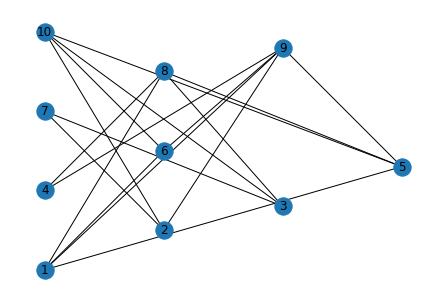

In [3]:
import networkx as nx

lines = {'l1' :(1, 2, 9, 0.5, 2, (1.0, 1.0), 1.41), 'l2': (2, 1, 9.25, 0.5, 2, (2.0, 2.0), 1.41), 'l3': (3, 4, 9.4, 0.5, 1, (2.2, 2.0), 1.0), 'l4': (4, 3, 9.65, 0.5, 1, (2.2, 1.0), 1.0)}
temp = deepcopy(lines)
# del temp['l3']
# del temp['l4']

tripz = create_trips(9, 11, temp)
# print(tripz)
trip_x = []
trip_y = []
serv_trip = {}
VS = nx.Graph()
deadhead = []
trip_id = {}
ctr= 1
for t in tripz:
    line_id = int(t[0][1])

    serv_trip[ctr] = (line_id, t[1])
    VS.add_node(ctr, pos = (line_id, t[1]))
    trip_id[str(t)] = ctr
    ctr += 1

print(serv_trip)
deadhead = []

'''
Fix deadhead trips not showing in schedule
Visualise bus schedule
'''

for t in tripz:
    for s in serv_trip.items():
        n1 = serv_trip[trip_id[str(t)]]
        if n1[0] != s[1][0] :
            if t[2] <= s[1][1]:# and n1[0] = s[0]:
                deadhead.append([trip_id[str(t)], s[0]])

VS.add_edges_from(deadhead)
nx.draw(VS, serv_trip, with_labels = True)#)

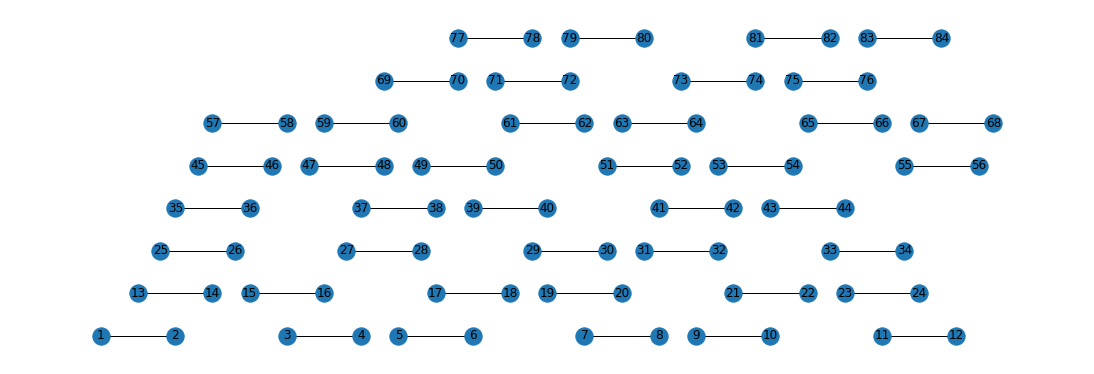

In [4]:
'''
SCHEDULE VISUALTISATION
'''

ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in bus_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('schedule_basic.png')
        
# fig, ax = plt.subplots(figsize=(15, 5))
# Trip_graph.add_nodes_from(pos)
# Trip_graph.add_edges_from(edges)
# nx.draw(Trip_graph, pos, with_labels = True,ax=ax)
# # ax.set_axis_on()
# # ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
# # nx.draw_networkx(Trip_graph, pos, with_labels = True, node_size = 0, width = 10.0, edge_color = 'red', alpha = 0.5)
# plt.savefig('schedule_basic.png')

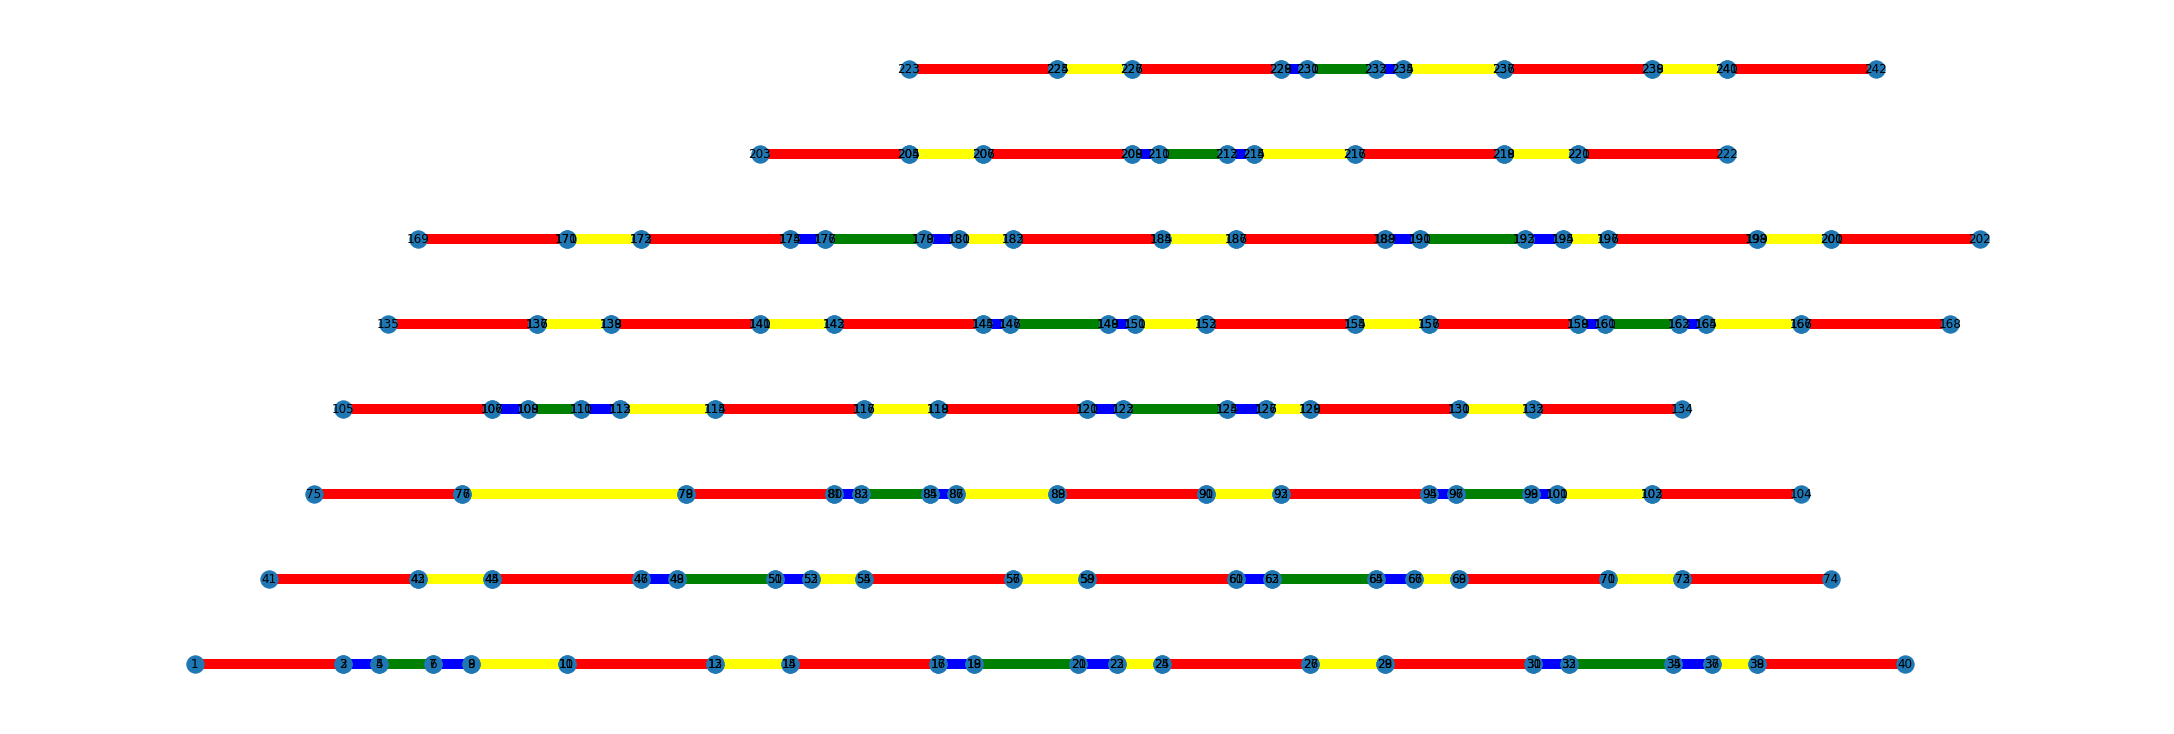

In [163]:
'''
REVISED: COMPLETE SCHEDULE
'''

new_schedule = {}
dh_tripz = deepcopy(deadhead_trips)

for bus in bus_schedule.keys():
    new_sch = []
    for trip in bus_schedule[bus]:
        new_sch.append([('t', trip[0]), trip[1], trip[2], trip[3]])
    
    for dh in dh_tripz:
            if dh[0] == bus:
                new_sch.append([('d', None), dh[3], dh[4], dh[5]])
    
    new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

# for bus in new_schedule.values():
#     print(bus)
#     print('-'*100)
# trav = 0
for bus in new_schedule.keys():
    charging_trips = []
    for t in range(1,len(new_schedule[bus])):
        if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
            if new_schedule[bus][t-1][0][0] == 'd' and new_schedule[bus][t-1][0][0] == new_schedule[bus][t][0][0]:
                label = 'c'
                trav = b_range
            else:
                label = 's'
                trav = new_schedule[bus][t-1][3]
            charging_trips.append([(label, None), new_schedule[bus][t-1][2], new_schedule[bus][t][1], trav])
#     for trip in charging_trips:
    new_schedule[bus].extend(charging_trips)
    new_schedule[bus].sort(key=lambda y: y[1])

# print(new_schedule[1])
# print('-'*100)

ctr = 1
pos = {}
edges = []
edge_color = []

new_trip_graph = nx.Graph()
for bus in new_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        if seq[0][0] == 't':
            edge_color.append('red')
        elif seq[0][0] == 'd':
            edge_color.append('blue')
        elif seq[0][0] == 'c':
            edge_color.append('green')
        else:
            edge_color.append('yellow')

fig = plt.figure(figsize=(30,10))
new_trip_graph.add_nodes_from(pos)
new_trip_graph.add_edges_from(edges)
nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
plt.savefig('schedule.png')

In [6]:
def stats(schedule):
    print('Schedule stats: ')
    print('-'*100)
    print('Number of buses: ', len(buses.keys()))
    print('-'*100)
    deadhead = {}
    charging = {}
    standing = 0
    ctr = 0
    for bus in schedule.items():
        for trip in bus[1]:
#             print(trip[0])
            if trip[0][0] == 'd':
                deadhead[bus[0]] = trip[2] - trip[1]                   
            elif trip[0][0] == 'c':
                charging[bus[0]]  = trip[2] - trip[1]
            elif trip[0][0] == 's':
                standing  += trip[2] - trip[1]
    print('Number of deadhead trips: ', len(deadhead.keys()))
    print('-'*100)
    print('Time spent deadheading: ', round(sum(deadhead.values()), 2))
    print('-'*100)
    print('Number of charging trips: ', len(charging.keys()))
    print('-'*100)
    print('Time spent charging: ', round(sum(charging.values()), 2))
    print('-'*100)
    print('Time spent standing: ', round(standing, 2))
#     print('-'*100)
#     print('Distance travelled: ', )
    

stats(new_schedule)

Schedule stats: 
----------------------------------------------------------------------------------------------------
Number of buses:  8
----------------------------------------------------------------------------------------------------
Number of deadhead trips:  8
----------------------------------------------------------------------------------------------------
Time spent deadheading:  0.88
----------------------------------------------------------------------------------------------------
Number of charging trips:  8
----------------------------------------------------------------------------------------------------
Time spent charging:  2.36
----------------------------------------------------------------------------------------------------
Time spent standing:  8.9


In [7]:
import random
from itertools import combinations

'''
RANDOM FEASIBLE SWAPS: MOVE ALL AFTER SWAP TIME
'''
trip_copy = create_trips(op_start, op_end, temp)

def trip_check(bus_1, bus_2, swap_time):
    trip_1 = None
    trip_2 = None
    temp_1 = None
    temp_2 = None
    
    for t in range(len(bus_1)):
        if bus_1[t][1] > swap_time:
            temp_1 =  bus_1[t]
            break

    for t in range(len(bus_2)):
        if bus_2[t][1] > swap_time:
            trip_2 = bus_2[t]
            temp_2 = bus_2[t]
    
    if temp_1 != None:
        for trip in trip_copy:
            if temp_1[0] == trip[0] and temp_1[1] == trip[1]:
                trip_1 = trip
                break

    if temp_2 != None:
        for trip in trip_copy:
            if temp_2[0] == trip[0] and temp_2[1] == trip[1]:
                trip_2 = trip
                break
    
    return (trip_1, trip_2)

sch = range(len(bus_schedule))
bus_sch = deepcopy(bus_schedule)
bus_1 = sch[0]+1
bus_2 = sch[1]+2

def swap_check(bus_schedule, swap_time):
    check = 0
    bus_sch = deepcopy(bus_schedule)
    bus_num = list(bus_sch.keys())
    while check == 0:
        random.shuffle(bus_num)
        t = random.uniform(op_start, op_end)

        bus_1 = bus_sch[bus_num[0]]
        bus_2 = bus_sch[bus_num[1]]
        old_bus_1 = deepcopy(bus_1)
        old_bus_2 = deepcopy(bus_2)
        trip_1, trip_2 = trip_check(bus_1, bus_2, t)

        if trip_1 != None and trip_2 != None:
            to_bus_1 = []
            to_bus_2 = []
            for trip in bus_1:
                if trip[1] > t:
                    to_bus_2.append(trip)
            for trip in bus_2:
                if trip[1] > t:
                    to_bus_1.append(trip)

            for el in to_bus_2:
                bus_1.remove(el)
            for el in to_bus_1:
                bus_2.remove(el)

            bus_1.extend(to_bus_1)
            bus_2.extend(to_bus_2)
            
            if new_sch_feas(bus_1, bus_2) == 0:
                t = random.uniform(op_start, op_end)
            else:
                if bus_1 != old_bus_2 and bus_2 != old_bus_1:
                    bus_1, bus_2 = fix_trav(bus_1, bus_2, t)
                    return (bus_1, bus_2, bus_sch)
        else:
#             print('a'*20)
            t = random.uniform(op_start, op_end)

def new_sch_feas(bus_1, bus_2):
    for t in range(1,len(bus_1)):
        if bus_1[t][0] == bus_1[t-1][0]:
            return 0
    
    for t in range(1,len(bus_2)):
        if bus_2[t][0] == bus_2[t-1][0]:
            return 0
    
    return 1

def fix_trav(bus_1, bus_2, swap_time):
    for trip in range(len(bus_1)):
        if bus_1[trip][1] > swap_time:
            for t in trip_copy:
                if bus_1[trip][1] == t[1] and bus_1[trip][0] == t[0]:
                    bus_1[trip][-1] == bus_1[trip-1][-1] - t[-1]
    for trip in range(len(bus_2)):
        if bus_2[trip][1] > swap_time:
            for t in trip_copy:
                if bus_2[trip][1] == t[1] and bus_2[trip][0] == t[0]:
                    bus_2[trip][-1] == bus_2[trip-1][-1] - t[-1]
    
    return(bus_1, bus_2)
            
new_bus_1, new_bus_2, new_schd = swap_check(bus_sch, t)
print(new_bus_1)
print(new_bus_2)

[['l3', 9.4, 9.9, 3.0], ['l2', 11.25, 11.75, 2.24], ['l1', 12.0, 12.5, 0.83], ['l2', 13.25, 13.75, 2.24], ['l1', 14.0, 14.5, 0.83]]
[['l2', 9.25, 9.75, 2.59], ['l1', 10.0, 10.5, 1.18], ['l4', 10.65, 11.15, 2.0], ['l3', 11.9, 12.4, 2.75], ['l4', 12.65, 13.15, 1.75], ['l3', 13.9, 14.4, 2.75]]


In [8]:
# print(stop_dist)
for st in stop_dist.items():
    for d in st[1]:
        if d[1] == 0.05:
            d[1] = 0
    print(st[1])

[[1, 1.77], [2, 0.35], [3, 0.25], [4, 1.25], [0, 0]]
[[1, 0], [4, 1.2], [2, 1.41], [3, 1.56], [0, 1.77]]
[[2, 0], [3, 0.2], [0, 0.35], [4, 1.02], [1, 1.41]]
[[3, 0], [2, 0.2], [0, 0.25], [4, 1.0], [1, 1.56]]
[[4, 0], [3, 1.0], [2, 1.02], [1, 1.2], [0, 1.25]]


3
^^^^^
['l3', 9.4, 9.9, 3.0]
['l4', 10.65, 11.15, 2.0]
['l3', 11.9, 12.4, 2.75]
['l4', 12.65, 13.15, 1.75]
['l3', 14.4, 14.9, 4]
--------------------------------------------------
5
^^^^^
['l4', 9.65, 10.15, 3.0]
['l3', 10.4, 10.9, 2.0]
['l4', 11.15, 11.65, 1.0]
['l3', 12.4, 12.9, 2.75]
['l4', 13.15, 13.65, 1.75]
['l3', 13.9, 14.4, 4]
--------------------------------------------------
[1, 2, 0, 9.5, 9.62, 2.24]
[1, 0, 2, 9.8, 9.93, 3.65]
[1, 2, 0, 11.5, 11.62, 0.48]
[1, 0, 2, 11.97, 12.1, 3.65]
[1, 2, 0, 13.5, 13.62, 0.48]
[1, 0, 2, 13.97, 14.1, 3.65]
[2, 2, 0, 10.5, 10.62, 0.83]
[2, 0, 2, 10.95, 11.07, 3.65]
[2, 2, 0, 12.5, 12.62, 0.48]
[2, 0, 2, 12.97, 13.1, 3.65]
[4, 2, 0, 10.0, 10.12, 2.24]
[4, 0, 2, 10.3, 10.43, 3.65]
[4, 2, 0, 12.0, 12.12, 0.48]
[4, 0, 2, 12.47, 12.6, 3.65]
[6, 2, 0, 11.0, 11.12, 0.83]
[6, 0, 2, 11.45, 11.57, 3.65]
[6, 2, 0, 13.0, 13.12, 0.48]
[6, 0, 2, 13.47, 13.6, 3.65]
[7, 3, 0, 12.15, 12.24, 1.75]
[7, 0, 3, 12.47, 12.56, 3.75]
[8, 3, 0, 12.65, 12.74, 1.75]
[

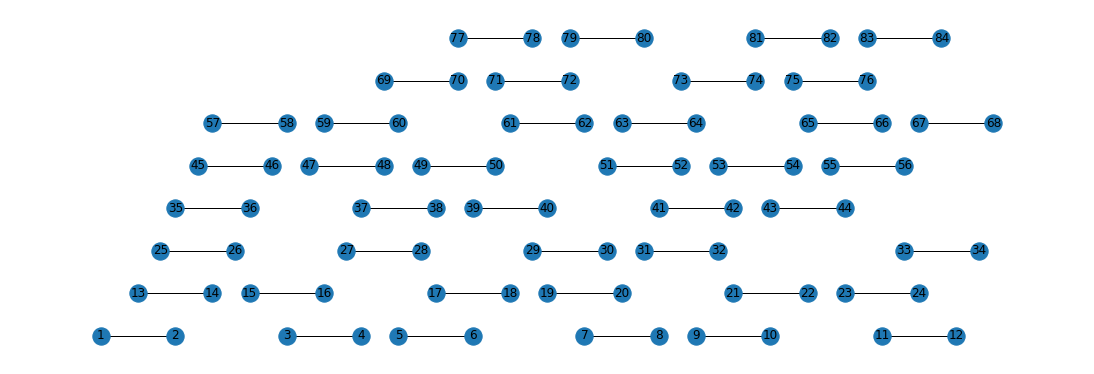

In [147]:
import random
from itertools import combinations

'''
RANDOM FEASIBLE SWAPS: MOVE THE FIRST TRIPS AFTER SWAP TIME;
INSERT REST GREEDILY

'''

def trip_check(bus_1, bus_2, swap_time):
    trip_copy = create_trips(op_start, op_end, temp)
    trip_1 = None
    trip_2 = None
    temp_1 = None
    temp_2 = None
    
    for t in range(len(bus_1)):
        if bus_1[t][1] > swap_time:
            temp_1 =  bus_1[t]
            break

    for t in range(len(bus_2)):
        if bus_2[t][1] > swap_time:
            temp_2 = bus_2[t]
            break
    
    if temp_1 != None:
        for trip in trip_copy:
            if temp_1[0] == trip[0] and temp_1[1] == trip[1]:
                trip_1 = trip
                break

    if temp_2 != None:
        for trip in trip_copy:
            if temp_2[0] == trip[0] and temp_2[1] == trip[1]:
                trip_2 = trip
                break
    
    return (trip_1, trip_2)

sch = range(len(bus_schedule))
bus_sch = deepcopy(bus_schedule)
bus_1 = sch[0]+1
bus_2 = sch[1]+2

def swap_check(bus_schedule, dh_trips):
    check = 0
#     dh_trips_new = deepcopy(dh_trips)
#     bus_sch = deepcopy(bus_schedule)
#     bus_num = list(bus_sch.keys())
    while check == 0:
        dh_trips_new = deepcopy(dh_trips)
        bus_sch = deepcopy(bus_schedule)
        bus_num = list(bus_sch.keys())
        random.shuffle(bus_num)
        t = random.uniform(op_start, op_end)
        bus_1 = bus_sch[bus_num[0]]
        bus_2 = bus_sch[bus_num[1]]
        old_bus_1 = deepcopy(bus_1)
        old_bus_2 = deepcopy(bus_2)
        
        trip_1, trip_2 = trip_check(bus_1, bus_2, t)

        if trip_1 != None and trip_2 != None:
            temp_1 = None
            temp_2 = None
            rem_trips = []

            for trip in bus_1:
                if trip[1] == trip_1[1] and trip[2] == trip_1[2]:
                    temp_1 = trip
                if trip[1] > trip_1[2]:
                    rem_trips.append(trip)
            
            for trip in bus_2:
                if trip[1] == trip_2[1] and trip[2] == trip_2[2]:
                    temp_2 = trip
                if trip[1] > trip_2[2]:
                    rem_trips.append(trip)
            
            bus_1.remove(temp_1)
            bus_2.remove(temp_2)
            for el in rem_trips:
                if el in bus_1:
                    bus_1.remove(el)
                if el in bus_2:
                    bus_2.remove(el)
            
            bus_1.append(trip_2)
            bus_2.append(trip_1)
            
            # delete deadheads for buses 1,2 after swap
            # in particular, delete deadheads if their end time exceeds swapped trip's start time
            for dh in dh_trips:
#                 if dh[0] == bus_num[0] or dh[0] == bus_num[1]:
#                     dh_trips_new.remove(dh)
                if dh[0] == bus_num[0]:
#                     if dh[-2] > bus_1[-1][1]:
                    dh_trips_new.remove(dh)
                elif dh[0] == bus_num[1]:
#                     if dh[-2] > bus_2[-1][1]:
                    dh_trips_new.remove(dh)
            
            # remove last from depot
            max_1 = 0
            max_2 = 0
            max_1_dh = []
            max_2_dh = []
            for dh in dh_trips_new:
                if dh[0] == bus_num[0]:
                    if dh[-2] > max_1:
                        max_1 = dh[-2]
                        max_1_dh = dh
                if dh[0] == bus_num[1]:
                    if dh[-2] > max_2:
                        max_2 = dh[-2]
                        max_2_dh = dh
            
            last_1 = None
            last_2 = None
            
#             print(max_1_dh)
#             print(max_2_dh)
#             print('A'*100)
            if  max_1_dh != []:
                if max_1_dh[-2] > bus_1[-1][-2]:
                    last_1 = max_1_dh
            if max_2_dh != []:
                if max_2_dh[-2] > bus_2[-1][-2]:
                    last_2 = max_2_dh

            nsf1 = new_sch_feas_test(bus_1, bus_num[0], last_1)
            nsf2 = new_sch_feas_test(bus_2, bus_num[1], last_2)
            if nsf1[0] == 0 or nsf2[0] == 0:
#                 t = random.uniform(op_start, op_end)
                continue
            else:
                if bus_1 != old_bus_2 and bus_2 != old_bus_1:
                    bus_1_dh = nsf1[1]
                    bus_2_dh = nsf2[1]
#                     print(bus_1_dh, ' & ', bus_2_dh)
                    if bus_1_dh is None and bus_2_dh is None:
                        continue
                    else:
                        # SOMETHING WRONG WITH DEADHEAD; THERE ARE EXTRAS/DUPLICATES
                        if bus_1_dh is not None:
                            dh_trips_new.extend(bus_1_dh)
                            
                        if bus_2_dh is not None:
                            dh_trips_new.extend(bus_2_dh)
                            
                        for trip in rem_trips:
                            for orig_trip in trip_copy:
                                if trip[0] == orig_trip[0] and trip[1] == orig_trip[1] and trip[2] == orig_trip[2]:
                                    trip[-1] = orig_trip[-1]
                            
                        return (bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, dh_trips_new)

        else:
            t = random.uniform(op_start, op_end)

def new_sch_feas_test(bus, bus_id, last):
#     print(bus)
    if len(bus) > 1:
        if bus[-1][0] == bus[-2][0]:
#             print('a')
            return [0, None]
            # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
        else:
            # FIGURE OUT LAST TRIP; DEADHEAD OR SERVICE
            start_stop = lines[bus[-1][0]][0]
            end_stop = lines[bus[-1][0]][1]
            
            if last is None:
                prev_stop = lines[bus[-2][0]][1]
                prev_trip_end = bus[-2][2]
                prev_trip_start = bus[-2][1]
                rem_fuel = bus[-2][-1]
                prev_stop_dists = possible_swap(prev_stop, stop_dist)
                for d in prev_stop_dists:
                    if d[0] == 0:
                        charge_trip_next = d[1]
            else:
#                 print(last)

                prev_stop = last[2]
                prev_trip_end = last[-2]
                prev_trip_start = last[-3]
                rem_fuel = last[-1]
                charge_trip_next = 0
            
            curr_trip_start = bus[-1][1]

            for st in stop_dist[prev_stop]:
#                 print(st)
                if start_stop == st[0]:
                    if round(curr_trip_start - prev_trip_end, 2) < round(st[1]/speed, 2):
                        return [0, None]
                        # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
                    else:
                        
                        start_stop_dists = possible_swap(start_stop, stop_dist)
                        for d in start_stop_dists:
                            if d[0] == 0:
                                charge_trip_to = d[1]
                        
                        # CHECKING IF BUS CAN MAKE THE NEWLY ADDED TRIP
                        # NEXT CONDITION CHECKS FOR FUEL; SECOND LAST + DEADHEAD TO LAST + LAST
                        if rem_fuel - st[1] - bus[-1][-1] <= 0:
                            # ADD CHARGING TIME
                            refuel_time = round((b_range - rem_fuel + charge_trip_next) * 0.1, 2)
                            if prev_trip_end + refuel_time + (charge_trip_next + charge_trip_to)/speed > curr_trip_start:
                                return [0, None]
                                # NOT ENOUGH FUEL FOR THE LAST TRIP AND NO TIME IN BETWEEN TO CHARGE
                            else: #CHECK IF TIME FRAME ENOUGH FOR CHARGING
                                new_dh = insert_charging_trip(bus_id, bus[-2], bus[-1])
#                                 print('a', new_dh)
#                                 print(bus[-1][-1])
                                bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)
                                return [1, new_dh]
                                # CHARGING POSSIBLE IN BETWEEN

                        else:
                            if rem_fuel - st[1] - bus[-1][-1] - charge_trip_to <= 0:
                                return [0, None]
                            else:
                                new_dh = insert_charging_trip(bus_id, bus[-1], None)
                                if new_dh is None:
                                    return [0, None]
                                else:
                                    bus[-1][-1] = b_range #round(rem_fuel - bus[-1][-1] - st[1], 2)
                                    return [1, new_dh]
                            # LAST TRIP POSSIBLE
    else:
        bus[-1][-1] = round(b_range - bus[-1][-1], 2)
        return [1, None]
        # SWAPPED TRIP IS THE FIRST POSSIBLE

def insert_charging_trip(bus_id, second_last_trip, last_trip):
    new_dh_trips = []
    trav = second_last_trip[-1]
    curr_stop = lines[second_last_trip[0]][1]
    curr_time = second_last_trip[2]

    for d in stop_dist[curr_stop]:
        if d[0] == 0:
            charge_trip_curr = d[1]

    trip_to_depot = [bus_id, curr_stop, depot_node[0], curr_time, round(curr_time + (charge_trip_curr/speed),2), round(trav - charge_trip_curr,2)]
    
    new_dh_trips.append(trip_to_depot)
    
    refuel_time = round((b_range - trav + charge_trip_curr) * 0.1, 2)
    # CONSIDER PARTIAL CHARGING: max(?)
    
    curr_time_new = round(curr_time + (charge_trip_curr/speed) + refuel_time, 2)
    
    if last_trip is not None:
        nxt_stop_dists = possible_swap(lines[last_trip[0]][0], stop_dist)
        for d in nxt_stop_dists:
            if d[0] == 0:
                charge_trip_next = d[1]
        
        new_trav = round(b_range - charge_trip_next, 2)
#         if curr_time_new + (charge_trip_curr/speed) <= op_end:
        
        trip_from_depot = [bus_id, depot_node[0], lines[last_trip[0]][0], curr_time_new, round(curr_time_new + (charge_trip_next/speed),2), new_trav]
#         if trip_from_depot[-2] > last_trip[1]:
#             return None
#         else:
        new_dh_trips.append(trip_from_depot)
#         print(new_trav)
        return new_dh_trips
#         else:
#             l
    else:
        if trip_to_depot[-1] < 0:
            return None, None
        else:
            return new_dh_trips

# CAN POSSIBLY REMOVE DEADHEAD TRIPS LEAVING DEPOT

check = 0
dht = deepcopy(deadhead_trips)

new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new = swap_check(bus_sch, dht)


# for i in range(1000):
#     if check == 1:
#         break
#     bus_sch = deepcopy(bus_schedule)
#     new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2 = swap_check(bus_sch, t)
#     for i in range(1,len(new_bus_1)):
#         if new_bus_1[i-1][0] == new_bus_1[i][0]:
#             print(new_bus_1, new_bus_2, old_bus_1, old_bus_2)
#             check == 1
#             break
#     if check == 1:
#         break
#     for i in range(1,len(new_bus_2)):
#         if new_bus_2[i-1][0] == new_bus_2[i][0]:
#             print(new_bus_1, new_bus_2, old_bus_1, old_bus_2)
#             check == 1
#             break
# print('-'*100)

# print(old_bus_1)
# print(old_bus_2)
# print('^'*50)
# print(new_bus_1)
# print(new_bus_2)
# print('-'*50)
# for dh in dht:
#     print(dh)

# print(len(deadhead_trips),', ', len(dht_new))

# for i in range(1,len(new_bus_1)):
#     if new_bus_1[i-1][0] == new_bus_1[i][0]:
#         print(new_bus_1)
#         break

# for i in range(1,len(new_bus_2)):
#     if new_bus_2[i-1][0] == new_bus_2[i][0]:
#         print(new_bus_2)
#         break

'''
ADD DEADHEADS FOR WHEN BUS CHANGES LINES
'''

# print(rem_trips)
# print('-'*50)

# print(new_bus_1)
# print('-'*50)

temp_sch = {}
for bus in bus_sch.items():
    if old_bus_1 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]
    elif old_bus_2 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]


for bus in temp_sch.items():
    print(bus[0])
    print('^'*5)
    for t in bus[1]:
        print(t)
    print('-'*50)

temp_dht = []

for dh in temp_dht_new:
    if dh is not None:
        print(dh)
        if dh[0] in temp_sch.keys():
#             if dh not in temp_dht:
            temp_dht.append(dh)
print('-'*50)

for dh in temp_dht:
    print(dh)
# print('-'*50)

dht_new = deepcopy(temp_dht)
# for dh in dht_new:
#     if dh[0] in temp_sch.keys()
#         print(dh)  

ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_schd.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))      
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('new_schedule_basic.png')

In [181]:
def trip_check(bus_1, bus_2, swap_time):
    trip_copy = create_trips(op_start, op_end, temp)
    
    trip_1 = None
    trip_2 = None
    temp_1 = None
    temp_2 = None
    
    for t in range(len(bus_1)):
        if bus_1[t][1] > swap_time:
            temp_1 =  bus_1[t]
            break

    for t in range(len(bus_2)):
        if bus_2[t][1] > swap_time:
            temp_2 = bus_2[t]
            break
    
    if temp_1 != None:
        for trip in trip_copy:
            if temp_1[0] == trip[0] and temp_1[1] == trip[1]:
#                 print(trip)
                trip_1 = trip
                break

    if temp_2 != None:
        for trip in trip_copy:
            if temp_2[0] == trip[0] and temp_2[1] == trip[1]:
#                 print(trip)
                trip_2 = trip
                break
    
#     print(bus_1)
#     print(bus_2)
#     print('%'*50)
    return (trip_1, trip_2)

def swap_check(bus_schedule, dh_trips):
    check = 0
#     dh_trips_new = deepcopy(dh_trips)
#     bus_sch = deepcopy(bus_schedule)
#     bus_num = list(bus_sch.keys())
    while check == 0:
        dh_trips_new = deepcopy(dh_trips)
        bus_sch = deepcopy(bus_schedule)
        bus_num = list(bus_sch.keys())
        random.shuffle(bus_num)
        t = random.uniform(op_start, op_end)
        bus_1 = bus_sch[bus_num[0]]
        bus_2 = bus_sch[bus_num[1]]
        old_bus_1 = deepcopy(bus_1)
        old_bus_2 = deepcopy(bus_2)
        
        trip_1, trip_2 = trip_check(bus_1, bus_2, t)
        
        if trip_1 != None and trip_2 != None:
            temp_1 = None
            temp_2 = None
            rem_trips = []

            for trip in bus_1:
                if trip[1] == trip_1[1] and trip[2] == trip_1[2]:
                    temp_1 = trip
                if trip[1] > trip_1[2]:
                    rem_trips.append(trip)
            
            for trip in bus_2:
                if trip[1] == trip_2[1] and trip[2] == trip_2[2]:
                    temp_2 = trip
                if trip[1] > trip_2[2]:
                    rem_trips.append(trip)
            
            bus_1.remove(temp_1)
            bus_2.remove(temp_2)
            for el in rem_trips:
                if el in bus_1:
                    bus_1.remove(el)
                if el in bus_2:
                    bus_2.remove(el)
            
#             print(trip_1, trip_2)
#             print('%'*50)
            
            bus_1.append(trip_2)
            bus_2.append(trip_1)
            
            # delete deadheads for buses 1,2 after swap
            # in particular, delete deadheads if their end time exceeds swapped trip's start time
            for dh in dh_trips:
#                 if dh[0] == bus_num[0] or dh[0] == bus_num[1]:
#                     dh_trips_new.remove(dh)
                if dh[0] == bus_num[0]:
                    if dh[-2] > bus_1[-1][1]:
                        dh_trips_new.remove(dh)
                elif dh[0] == bus_num[1]:
                    if dh[-2] > bus_2[-1][1]:
                        dh_trips_new.remove(dh)
            
            # remove last from depot
            max_1 = 0
            max_2 = 0
            max_1_dh = []
            max_2_dh = []
            for dh in dh_trips_new:
                if dh[0] == bus_num[0]:
                    if dh[-2] > max_1 and dh[1] != 0:
                        max_1 = dh[-2]
                        max_1_dh = dh
                if dh[0] == bus_num[1]:
                    if dh[-2] > max_2 and dh[1] != 0:
                        max_2 = dh[-2]
                        max_2_dh = dh
            
            last_1 = None
            last_2 = None
            
#             print(max_1_dh)
#             print(max_2_dh)
#             print('A'*100)
            if  max_1_dh != []:
                if max_1_dh[-2] > bus_1[-1][1]:
                    last_1 = max_1_dh
            if max_2_dh != []:
                if max_2_dh[-2] > bus_2[-1][1]:
                    last_2 = max_2_dh
            
#             print(last_1, last_2)
            
            nsf1 = new_sch_feas_test(bus_1, bus_num[0], last_1, trip_2)
            nsf2 = new_sch_feas_test(bus_2, bus_num[1], last_2, trip_1)
            if nsf1[0] == 0 or nsf2[0] == 0:
#                 t = random.uniform(op_start, op_end)
                continue
            else:
                if bus_1 != old_bus_2 and bus_2 != old_bus_1:
                    bus_1_dh = nsf1[1]
                    bus_2_dh = nsf2[1]
#                     print(bus_1_dh, ' & ', bus_2_dh)
                    if bus_1_dh is None and bus_2_dh is None:
                        continue
                    else:
                        # SOMETHING WRONG WITH DEADHEAD; THERE ARE EXTRAS/DUPLICATES
                        if bus_1_dh is not None:
                            dh_trips_new.extend(bus_1_dh)
                            
                        if bus_2_dh is not None:
                            dh_trips_new.extend(bus_2_dh)
                            
                        for trip in rem_trips:
                            for orig_trip in trip_copy:
                                if trip[0] == orig_trip[0] and trip[1] == orig_trip[1] and trip[2] == orig_trip[2]:
                                    trip[-1] = orig_trip[-1]
                            
                        return (bus_1, bus_2, bus_sch, rem_trips, old_bus_1, old_bus_2, dh_trips_new)

        else:
            t = random.uniform(op_start, op_end)

def new_sch_feas_test(bus, bus_id, last, tripd):
#     print(bus_id, last, bus, tripd)
    
    if len(bus) > 1:
        if bus[-1][0] == bus[-2][0]:
#             print('a')
            return [0, None]
            # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
        else:
            # FIGURE OUT LAST TRIP; DEADHEAD OR SERVICE
            start_stop = lines[bus[-1][0]][0]
            end_stop = lines[bus[-1][0]][1]
            
            if last is None:
                prev_stop = lines[bus[-2][0]][1]
                prev_trip_end = bus[-2][2]
                prev_trip_start = bus[-2][1]
                rem_fuel = bus[-2][-1]
                prev_stop_dists = possible_swap(prev_stop, stop_dist)
                for d in prev_stop_dists:
                    if d[0] == 0:
                        charge_trip_next = d[1]
                        
#                 print(bus_id, bus)
            else:
#                 print(last)

                prev_stop = last[2]
                prev_trip_end = last[-2]
                prev_trip_start = last[-3]
                rem_fuel = last[-1]
                charge_trip_next = 0
            
            curr_trip_start = bus[-1][1]

            for st in stop_dist[prev_stop]:
#                 print(st)
                if start_stop == st[0]:
                    if round(curr_trip_start - prev_trip_end, 2) < round(st[1]/speed, 2):
                        return [0, None]
                        # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
                    else:
#                         print('aaaaaa', bus)
                        start_stop_dists = possible_swap(start_stop, stop_dist)
                        for d in start_stop_dists:
                            if d[0] == 0:
                                charge_trip_to = d[1]
                        
                        # CHECKING IF BUS CAN MAKE THE NEWLY ADDED TRIP
                        # NEXT CONDITION CHECKS FOR FUEL; SECOND LAST + DEADHEAD TO LAST + LAST
                        
                        refuel_time = round((b_range - rem_fuel + charge_trip_next) * 0.1, 2)
                        
#                         print('c', rem_fuel, st[1], bus[-1][-1], rem_fuel - st[1] - bus[-1][-1])
#                         print('d', bus_id, prev_trip_end, curr_trip_start, round(prev_trip_end + refuel_time + (charge_trip_next + charge_trip_to)/speed,2))
#                         print('$'*20)
                        
                        if rem_fuel - st[1] - bus[-1][-1] <= 0:
                            # ADD CHARGING TIME
#                             print(bus_id, prev_trip_end, curr_trip_start, round(prev_trip_end + refuel_time + (charge_trip_next + charge_trip_to)/speed,2))
                            if prev_trip_end + refuel_time + (charge_trip_next + charge_trip_to)/speed > curr_trip_start:
                                return [0, None]
                                # NOT ENOUGH FUEL FOR THE LAST TRIP AND NO TIME IN BETWEEN TO CHARGE
                            else: #CHECK IF TIME FRAME ENOUGH FOR CHARGING
                                new_dh = insert_charging_trip(bus_id, bus[-2], bus[-1])
#                                 print('a', bus_id, prev_trip_end, curr_trip_start, round(prev_trip_end + refuel_time + (charge_trip_next + charge_trip_to)/speed,2))
#                                 print('^'*50)
                                bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)
                                return [1, new_dh]
                                # CHARGING POSSIBLE IN BETWEEN

                        else:
                            end_stop_dists = possible_swap(end_stop, stop_dist)
                            for d in end_stop_dists:
                                if d[0] == 0:
                                    charge_trip_end = d[1]
#                             if prev_trip_end + refuel_time + (charge_trip_next + charge_trip_to)/speed > curr_trip_start:
                            if rem_fuel - st[1] - bus[-1][-1] - charge_trip_end <= 0:
                                return [0, None]
#                                 else:
#                                     print('FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFf')
#                                     new_dh = insert_charging_trip(bus_id, bus[-2], bus[-1])
#                                     bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)
#                                     return [1, new_dh]
                            else:
                                if prev_trip_end + refuel_time + (charge_trip_next + charge_trip_to)/speed < curr_trip_start:
#                                     print('HELO')
                                    new_dh = insert_charging_trip(bus_id, bus[-2], bus[-1])
                                    bus[-1][-1] = round(b_range - bus[-1][-1] - charge_trip_to, 2)
                                    return [1, new_dh]
                                else:
                                    new_dh = insert_charging_trip(bus_id, bus[-1], None)
                                    if new_dh is None:
                                        return [0, None]
                                    else:
    #                                     print('b', bus_id, rem_fuel, st[1], bus[-1][-1], charge_trip_end)
                                        bus[-1][-1] = round(rem_fuel - bus[-1][-1] - st[1], 2)
                                        return [1, new_dh]
                            # LAST TRIP POSSIBLE
    else:
#         print(last, bus[-1][-1])
        bus[-1][-1] = round(b_range - bus[-1][-1], 2)
#         print(bus[-1][-1])
        return [1, None]
        # SWAPPED TRIP IS THE FIRST POSSIBLE

def insert_charging_trip(bus_id, second_last_trip, last_trip):
    new_dh_trips = []
    trav = second_last_trip[-1]
    curr_stop = lines[second_last_trip[0]][1]
    curr_time = second_last_trip[2]

    for d in stop_dist[curr_stop]:
        if d[0] == 0:
            charge_trip_curr = d[1]

    trip_to_depot = [bus_id, curr_stop, depot_node[0], curr_time, round(curr_time + (charge_trip_curr/speed),2), round(trav - charge_trip_curr,2)]
    
    new_dh_trips.append(trip_to_depot)
    
    refuel_time = round((b_range - trav + charge_trip_curr) * 0.1, 2)
    # CONSIDER PARTIAL CHARGING: max(?)
    
    curr_time_new = round(curr_time + (charge_trip_curr/speed) + refuel_time, 2)
    
    if last_trip is not None:
#         print(last_trip)
        nxt_stop_dists = possible_swap(lines[last_trip[0]][0], stop_dist)
        for d in nxt_stop_dists:
            if d[0] == 0:
                charge_trip_next = d[1]
        
        new_trav = round(b_range - charge_trip_next, 2)
#         if curr_time_new + (charge_trip_curr/speed) <= op_end:
        
        trip_from_depot = [bus_id, depot_node[0], lines[last_trip[0]][0], curr_time_new, round(curr_time_new + (charge_trip_next/speed),2), new_trav]
#         if trip_from_depot[-2] > last_trip[1]:
#             return None
#         else:
        new_dh_trips.append(trip_from_depot)
#         print(new_trav)
#         if trip_to_depot[-2] > last_trip[1]:
#             return None, None
#         else:
        return new_dh_trips
#         else:
#             l
    else:
        if trip_to_depot[-1] < 0:
            return None, None
        else:
            return new_dh_trips

tempsch = {}
for bus in bus_sch.keys():
    if bus == 1 or bus == 5:
        tempsch[bus] = bus_sch[bus]

# for bus in tempsch.items():
#     print(bus[0])
#     print('^'*5)
#     for t in bus[1]:
#         print(t)
#     print('-'*50)
        
new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(bus_sch, dht)

temp_sch = {}
for bus in bus_sch.items():
    if old_bus_1 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]
    elif old_bus_2 == bus[1]:
        temp_sch[bus[0]] = new_schd[bus[0]]

print('-'*50)
        
for bus in temp_sch.items():
    print(bus[0])
    print('^'*5)
    for t in bus[1]:
        print(t)
    print('-'*50)

temp_dht = []

for dh in dht_new:
    if dh is not None:
        if dh[0] in temp_sch.keys():
            print(dh)

--------------------------------------------------
1
^^^^^
['l1', 9, 9.5, 2.59]
['l2', 10.25, 10.75, 2.24]
['l1', 11.0, 11.5, 0.83]
['l3', 12.4, 12.9, 2.75]
--------------------------------------------------
5
^^^^^
['l4', 9.65, 10.15, 3.0]
['l3', 10.4, 10.9, 2.0]
['l4', 11.15, 11.65, 1.0]
['l2', 12.25, 12.75, 2.24]
--------------------------------------------------
[1, 2, 0, 9.5, 9.62, 2.24]
[1, 0, 2, 9.8, 9.93, 3.65]
[1, 2, 0, 11.5, 11.62, 0.48]
[1, 0, 2, 11.97, 12.1, 3.65]
[5, 3, 0, 11.65, 11.74, 0.75]
[5, 0, 3, 12.07, 12.16, 3.75]
[1, 2, 0, 11.5, 11.62, 0.48]
[1, 0, 3, 11.97, 12.06, 3.75]
[5, 3, 0, 11.65, 11.74, 0.75]
[5, 0, 2, 12.07, 12.2, 3.65]


In [31]:
# print(rem_trips)
'''
[4, 2, 0, 10.0, 10.12, 2.24]
[4, 0, 2, 10.3, 10.43, 3.65]
[4, 2, 0, 12.0, 12.12, 0.48]
[4, 0, 2, 12.47, 12.6, 3.65]

Bus 4 : 
['l1', 9.5, 10.0, 2.59]
['l2', 10.75, 11.25, 2.24]
['l1', 11.5, 12.0, 0.83]
['l2', 12.75, 13.25, 2.24]
['l1', 13.5, 14.0, 0.83]
**************************************************
Bus 7 : 
['l3', 10.9, 11.4, 3.0]
['l4', 11.65, 12.15, 2.0]
['l3', 12.9, 13.4, 2.75]
['l4', 13.65, 14.15, 1.75]
'''

for st in stop_dist.items():
    print(st)
# new_s, ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
# for dh in dht_new:
#     if dh[0] == 1:#in temp_sch.keys():
#         print(dh)
# print('-'*50)
# for dh in dht:
#     if dh[0] == 1:#in temp_sch.keys():
#         print(dh)


(0, [[1, 1.77], [2, 0.35], [3, 0.25], [4, 1.25], [0, 0]])
(1, [[1, 0], [4, 1.2], [2, 1.41], [3, 1.56], [0, 1.77]])
(2, [[2, 0], [3, 0.2], [0, 0.35], [4, 1.02], [1, 1.41]])
(3, [[3, 0], [2, 0.2], [0, 0.25], [4, 1.0], [1, 1.56]])
(4, [[4, 0], [3, 1.0], [2, 1.02], [1, 1.2], [0, 1.25]])


[['l1', 13.0, 13.5, 1.41], ['l4', 13.15, 13.65, 1.0], ['l2', 14.25, 14.75, 1.41], ['l3', 14.4, 14.9, 1.0]]
--------------------------------------------------
[]


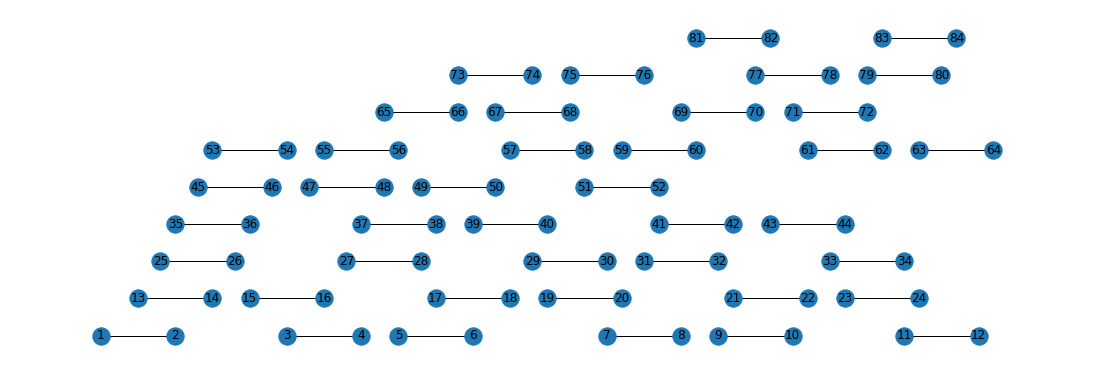

In [182]:
# def greedy_insert(schd, rem_tripz, dhT):

def new_stops(line_pool, trips, buses, deadhead, cov):
    lines = deepcopy(line_pool)
    rem_trips = []
    for bus in buses.keys():
        if trips == []:
            for i in range(len(buses)):
                if buses[i+1] == []:
                    del buses[i+1]
            return (buses, cov, deadhead)
            break
        if buses[bus] == []:
            buses[bus] = [trips[0]]
            buses[bus][-1][-1] = b_range - trips[0][-1]
            curr_stop = lines[trips[0][0]][1]
            trips.pop(0)
            cov += 1

        curr_time_new = 0
        
        charge_check = 0
        
        new_trav = 0
        
        t = 0
        trip_num = len(trips)
        while t < trip_num:
#             print(trips[t])
            if charge_check == 0:
                trav = buses[bus][-1][-1]
                curr_time = buses[bus][-1][2]
            else:
                curr_time = curr_time_new
                trav = new_trav
                charge_check = 0
            
            if deadhead != []:
                max_dh = 0
                temp_dh = None
                for dh in deadhead:
                    if dh[0] == bus:
                        if dh[-2] > max_dh:
                            max_dh = dh[-2]
                            temp_dh = dh
                if max_dh > buses[bus][-1][-2]:
                    curr_stop = temp_dh[2]
                else:
                    curr_stop = lines[buses[bus][-1][0]][1]
            else:
                curr_stop = lines[buses[bus][-1][0]][1]
            
            # NEED TO CHANGE nxt_stop

            nxt_stop = lines[trips[t][0]][0]
            next_stop_dist = lines[buses[bus][-1][0]][-1]
            dists = possible_swap(curr_stop, stop_dist)
            
#             if bus == 1:
#             print(bus, curr_stop, curr_time, trav, nxt_stop, trips[t])
            
            for line in lines.values():
                if line[0] == curr_stop:
                    next_dists = possible_swap(nxt_stop, stop_dist)

            for d in dists:
                if d[0] == 0:
                    charge_trip_curr = d[1]
            
            for d in next_dists:
                if d[0] == 0:
                    charge_trip_next = d[1]
            
            for st in dists:
                if st[1]/speed <= trips[t][1] - curr_time:
                    # ?????????????????????????????
                    if curr_stop == lines[trips[t][0]][0]:
#                         if bus == 7:
#                             print(trips[t])
#                             print('a', st, curr_time, curr_stop, trips[t])
                        
                        nxt_stop_dist = trips[t][-1]
                        proj_trip = next_stop_dist + charge_trip_next
                        if trav - charge_trip_curr > 0: #REDUNDANT
                            if trav - proj_trip > 0:
                                rem_trips.append(trips[t])
                                trips[t][-1] = round(trav-trips[t][-1],2)
                                buses[bus].append(trips[t])
                                cov += 1
                                curr_time_new = trips[t][-2]
                                break
                            else:
                                charge_check = 1
                                trip_to_depot = [bus, curr_stop, depot_node[0], curr_time, round(curr_time + (charge_trip_curr/speed),2), round(trav - charge_trip_curr,2)]
                                if trip_to_depot not in deadhead:
                                    deadhead.append(trip_to_depot)
                                refuel_time = round((b_range - trav + charge_trip_curr) * 0.1, 2)
                                curr_time_new = round(curr_time + (charge_trip_curr/speed) + refuel_time, 2)
                                new_trav = round(b_range - charge_trip_curr,2)
                                trip_from_depot = [bus, depot_node[0], curr_stop, curr_time_new, round(curr_time_new + (charge_trip_curr/speed),2), new_trav]
                                if trip_from_depot not in deadhead:
                                    deadhead.append(trip_from_depot)
                                curr_time_new += charge_trip_curr/speed
                                t -= 1
                                break
            t += 1

        for trip in rem_trips:
            if trip in trips:
                trips.remove(trip)
    
    return (buses, cov, deadhead)    

ctr = 0

nschd = deepcopy(new_schd)
ndh_t = deepcopy(temp_dht)

# print(ndh_t)
rem_tripzz = deepcopy(rem_trips)
rem_tripzz.sort(key=lambda y: y[1])

# for dh in ndh_t:
# #     if dh[0] == 6 or dh[0] == 2:
#     print(dh)

print(rem_tripzz)
print('-'*50)

if rem_tripzz != []:
    while ctr < len(rem_tripzz):
        new_s, new_ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
#         print(ctr, rem_tripzz, len(dh_t))
        if new_ctr == ctr:
            new_s[len(new_s.keys())+1] = []
            ctr = new_ctr
#         if new_s == nschd:
#             print(ctr)
        for dh in dh_t:
            if dh not in ndh_t:
                ndh_t.append(dh_t)

print(rem_tripzz)
#         break
# if rem_tripzz != []:
#     for trip in rem_tripzz:
#         new_s[len(new_s.keys())+1] = [trip]
# print(new_s)
# new_s, ctr, dh_t = new_stop(lines, rem_trips, bus_sch, ctr)
# new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(bus_sch, dht)

# for bus in nschd.items():
#     if bus[0] == 6 or bus[0] == 2:
#         print('*'*50)
#         print('Bus ' + str(bus[0]) + ' : ')
#         for t in bus[1]:
#             print(t)
# print('-'*100)

ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_s.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('new_schedule_basiczz.png')

In [183]:
# ctr = 0
# rem_tripzz = [['l4', 11.65, 12.15, 2.0]]
# new_s, ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
# print(ctr, rem_tripzz)
print(new_s[7])

[['l3', 10.9, 11.4, 3.0], ['l4', 11.65, 12.15, 2.0], ['l3', 12.9, 13.4, 2.75], ['l4', 13.65, 14.15, 1.75]]


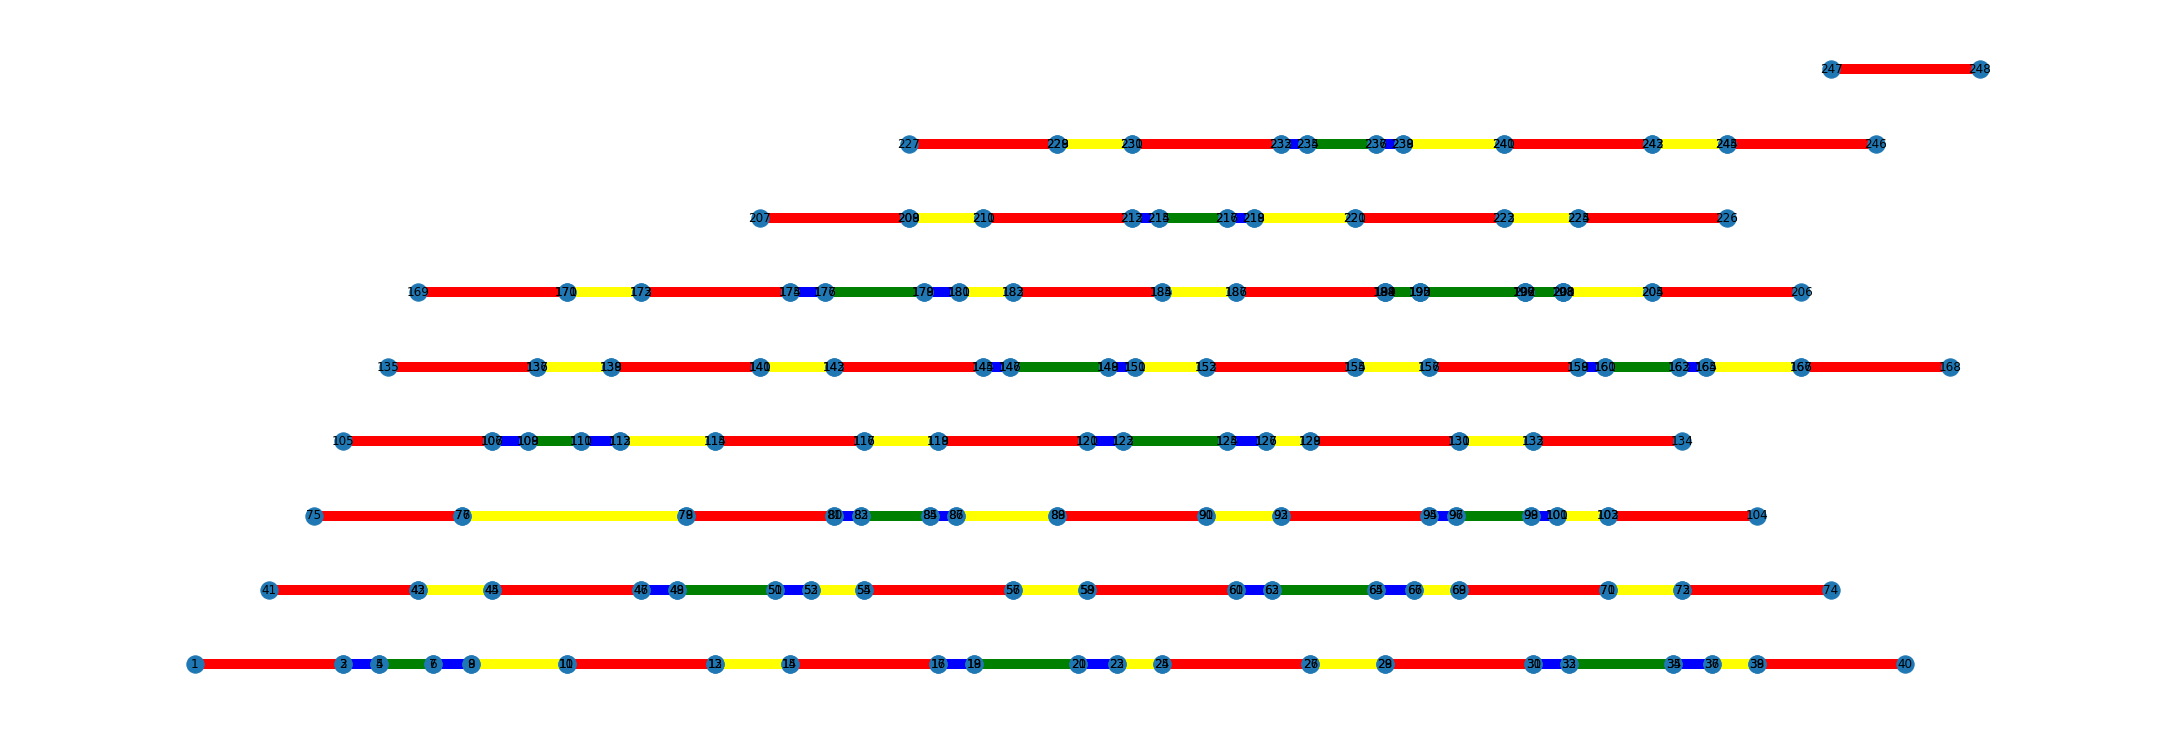

In [13]:
new_schedule = {}
# print(deadhead_trips)
dh_tripz = deepcopy(dht_new)

for bus in new_s.keys():
    new_sch = []
    for trip in new_s[bus]:
        new_sch.append(['t', trip[1], trip[2]])
    
    for dh in dh_tripz:
            if dh[0] == bus:
                new_sch.append(['d', dh[3], dh[4]])
    
    new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

for bus in new_schedule.keys():
    charging_trips = []
    for t in range(1,len(new_schedule[bus])):
        if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
            if new_schedule[bus][t-1][0] == 'd' and new_schedule[bus][t-1][0] == new_schedule[bus][t][0]:
                label = 'c'
            else:
                label = 's'
            charging_trips.append([label, new_schedule[bus][t-1][2], new_schedule[bus][t][1]])
#     for trip in charging_trips:
    new_schedule[bus].extend(charging_trips)
    new_schedule[bus].sort(key=lambda y: y[1])

ctr = 1
pos = {}
edges = []
edge_color = []

new_trip_graph = nx.Graph()
for bus in new_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        if seq[0] == 't':
            edge_color.append('red')
        elif seq[0] == 'd':
            edge_color.append('blue')
        elif seq[0] == 'c':
            edge_color.append('green')
        else:
            edge_color.append('yellow')

fig = plt.figure(figsize=(30,10))
new_trip_graph.add_nodes_from(pos)
new_trip_graph.add_edges_from(edges)
nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
plt.savefig('new_schedule.png')

In [184]:
def stats(schedule):
#     print('Schedule stats: ')
#     print('-'*100)
#     print('Number of buses: ', len(buses.keys()))
#     print('-'*100)
    deadhead = {}
    charging = {}
    standing = 0
    ctr = 0
    for bus in schedule.items():
        for trip in bus[1]:
            if trip[0][0] == 'd':
                deadhead[bus[0]] = trip[2] - trip[1]                   
            elif trip[0][0] == 'c':
                charging[bus[0]]  = trip[2] - trip[1]
            elif trip[0][0] == 's':
                standing  += trip[2] - trip[1]
#     print('Number of deadhead trips: ', len(deadhead.keys()))
#     print('-'*100)
#     print('Time spent deadheading: ', round(sum(deadhead.values()), 2))
#     print('-'*100)
#     print('Number of charging trips: ', len(charging.keys()))
#     print('-'*100)
#     print('Time spent charging: ', round(sum(charging.values()), 2))
#     print('-'*100)
#     print('Time spent standing: ', round(standing, 2))
    
    return round(500*len(buses.keys()) + 100*sum(deadhead.values()) + 50*sum(charging.values()),2)
    

print(stats(new_schedule))

4206.0


In [166]:
init_sch = deepcopy(new_schedule)

In [199]:
def best_sol(init_sch, scored_sch, iters, T):
    best_sch = deepcopy(init_sch)
    print(stats(scored_sch))
    for i in range(iters):
        new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, temp_dht_new = swap_check(best_sch, dht)
        ctr = 0
        
#         temp_sch = {}
#         for bus in best_sch.items():
#             if old_bus_1 == bus[1]:
#                 temp_sch[bus[0]] = new_schd[bus[0]]
#             elif old_bus_2 == bus[1]:
#                 temp_sch[bus[0]] = new_schd[bus[0]]

        temp_dht = []

        for dh in temp_dht_new:
            if dh is not None:
#                 if dh[0] in temp_sch.keys():
                temp_dht.append(dh)

        dht_new = deepcopy(temp_dht)
        
        
        nschd = deepcopy(new_schd)
        ndh_t = deepcopy(dht_new)
        rem_tripzz = deepcopy(rem_trips)
        rem_tripzz.sort(key=lambda y: y[1])

        if rem_tripzz != []:
            while ctr < len(rem_tripzz):
                new_s, new_ctr, dh_t = new_stops(lines, rem_tripzz, nschd, ndh_t, ctr)
                if new_ctr == ctr:
                    new_s[len(new_s.keys())+1] = []
                    ctr = new_ctr
                for dh in dh_t:
                    if dh not in ndh_t:
                        ndh_t.append(dh_t)
        
        new_schedule = {}
        dh_tripz = deepcopy(ndh_t)

        for bus in new_s.keys():
            new_sch = []
            for trip in new_s[bus]:
                new_sch.append(['t', trip[1], trip[2]])

            for dh in dh_tripz:
                    if dh[0] == bus:
                        new_sch.append(['d', dh[3], dh[4]])

            new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

        for bus in new_schedule.keys():
            charging_trips = []
            for t in range(1,len(new_schedule[bus])):
                if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
                    if new_schedule[bus][t-1][0] == 'd' and new_schedule[bus][t-1][0] == new_schedule[bus][t][0]:
                        label = 'c'
                    else:
                        label = 's'
                    charging_trips.append([label, new_schedule[bus][t-1][2], new_schedule[bus][t][1]])

            new_schedule[bus].extend(charging_trips)
            new_schedule[bus].sort(key=lambda y: y[1])

        score_1 = stats(best_sch)
        score_2 = stats(new_schedule)
        
        print(score_2)
        if score_1 > score_2:
            best_sch = new_s
        else:
            prob = random.uniform(0,1)
            if prob < math.exp((score_1 - score_2)*T):
                best_sch = new_schd
        
#         print(stats(best_sch))
    
    return (best_sch, ndh_t)

# print(stats(init_sch))
best, ndh = best_sol(bus_sch, init_sch, 50, 500)

4206.0
4238.5
4238.0
4314.0
4179.0
4179.0
4314.0
4238.0
4238.0
4179.0
4225.5
4314.0
4225.5
4238.0
4179.0
4238.0
4238.0
4238.0
4238.0
4238.0
4179.0
4314.0
4314.0
4314.0
4238.0
4238.0
4238.0
4314.0
4238.0
4238.5
4314.0
4238.0
4225.5
4314.0
4238.0
4237.0
4237.0
4314.0
4237.0
4238.5
4314.0
4314.0
4237.0
4179.0
4237.0
4314.0
4238.0
4179.0
4314.0
4179.0
4179.0


[1, 2, 0, 9.5, 9.62, 2.24]
[1, 0, 2, 9.8, 9.93, 3.65]
[1, 2, 0, 11.5, 11.62, 0.48]
[1, 0, 2, 11.97, 12.1, 3.65]
[1, 2, 0, 13.5, 13.62, 0.48]
[1, 0, 2, 13.97, 14.1, 3.65]
[2, 2, 0, 10.5, 10.62, 0.83]
[2, 0, 2, 10.95, 11.07, 3.65]
[2, 2, 0, 12.5, 12.62, 0.48]
[2, 0, 2, 12.97, 13.1, 3.65]
[3, 3, 0, 11.15, 11.24, 1.75]
[3, 0, 3, 11.47, 11.56, 3.75]
[3, 3, 0, 13.15, 13.24, 1.5]
[3, 0, 3, 13.49, 13.58, 3.75]
[4, 2, 0, 10.0, 10.12, 2.24]
[4, 0, 2, 10.3, 10.43, 3.65]
[4, 2, 0, 12.0, 12.12, 0.48]
[4, 0, 2, 12.47, 12.6, 3.65]
[6, 2, 0, 11.0, 11.12, 0.83]
[6, 0, 2, 11.45, 11.57, 3.65]
[6, 2, 0, 13.0, 13.12, 0.48]
[6, 0, 2, 13.47, 13.6, 3.65]
[7, 3, 0, 12.15, 12.24, 1.75]
[7, 0, 3, 12.47, 12.56, 3.75]
[5, 3, 0, 10.15, 10.24, 2.75]
[5, 0, 3, 10.36, 10.45, 3.75]


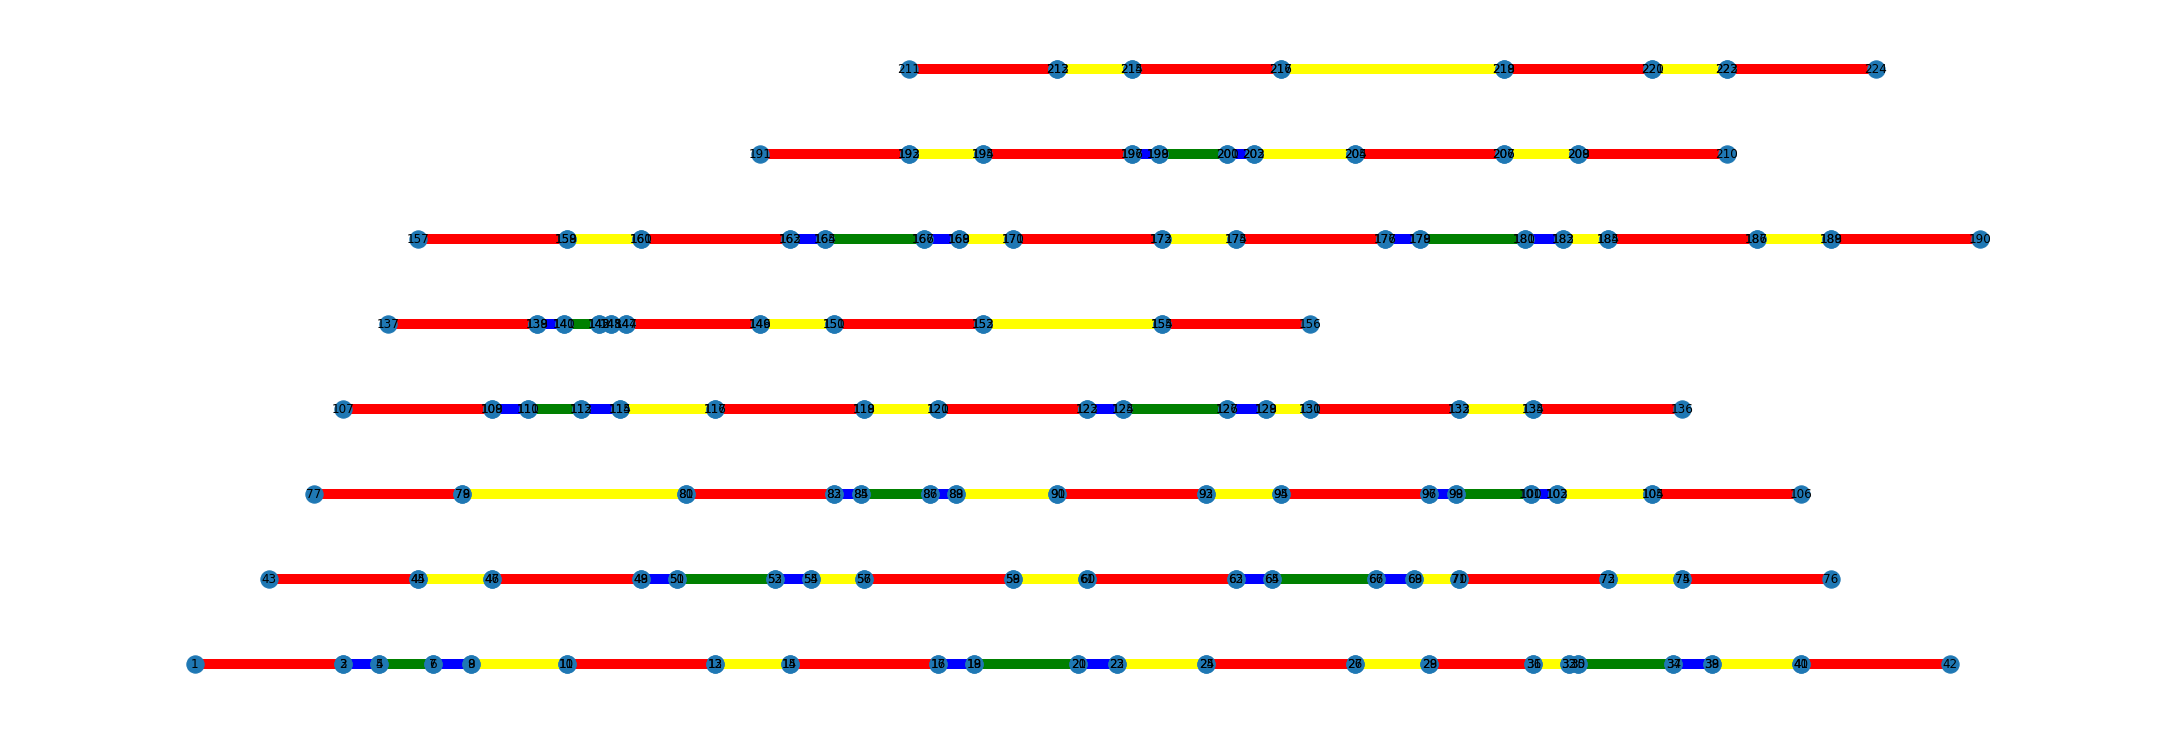

In [200]:
new_schedule = {}
# print(deadhead_trips)
dh_tripz = deepcopy(ndh)

for dh in dh_tripz:
    print(dh)

for bus in best.keys():
    new_sch = []
    for trip in new_s[bus]:
        new_sch.append(['t', trip[1], trip[2]])
    
    for dh in dh_tripz:
            if dh[0] == bus:
                new_sch.append(['d', dh[3], dh[4]])
    
    new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

for bus in new_schedule.keys():
    charging_trips = []
    for t in range(1,len(new_schedule[bus])):
        if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
            if new_schedule[bus][t-1][0] == 'd' and new_schedule[bus][t-1][0] == new_schedule[bus][t][0]:
                label = 'c'
            else:
                label = 's'
            charging_trips.append([label, new_schedule[bus][t-1][2], new_schedule[bus][t][1]])
#     for trip in charging_trips:
    new_schedule[bus].extend(charging_trips)
    new_schedule[bus].sort(key=lambda y: y[1])

ctr = 1
pos = {}
edges = []
edge_color = []

new_trip_graph = nx.Graph()
for bus in new_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        if seq[0] == 't':
            edge_color.append('red')
        elif seq[0] == 'd':
            edge_color.append('blue')
        elif seq[0] == 'c':
            edge_color.append('green')
        else:
            edge_color.append('yellow')

fig = plt.figure(figsize=(30,10))
new_trip_graph.add_nodes_from(pos)
new_trip_graph.add_edges_from(edges)
nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
plt.savefig('new_schedule.png')

In [16]:
n = deepcopy(new_schd)
cov = len(rem_trips)
print(cov)
b, cov, dh_trips = new_stop(lines, rem_trips, n, cov)
print(rem_trips)

6
[['l1', 11.5, 12.0, 0.83], ['l2', 12.75, 13.25, 2.24], ['l1', 13.5, 14.0, 0.83], ['l3', 11.9, 12.4, 2.75], ['l4', 12.65, 13.15, 1.75], ['l3', 13.9, 14.4, 2.75]]


In [11]:
# bus_sch = deepcopy(bus_schedule)
# dht = deepcopy(deadhead_trips)
# new_bus_1, new_bus_2, new_schd, rem_trips, old_bus_1, old_bus_2, dht_new = swap_check(bus_sch, dht)

for bus in bus_sch.items():
    print(bus[0])
    for trip in bus[1]:
        print(trip)
    print('^'*30)
print('-'*50)

for bus in new_schd.items():
    print(bus[0])
    for trip in bus[1]:
        print(trip)
    print('^'*30)
print('-'*50)

for dh in deadhead_trips:
    print(dh)
print('-'*50)

for dh in dht_new:
    print(dh)
print('-'*50)

1
['l1', 9, 9.5, 2.59]
['l2', 10.25, 10.75, 2.24]
['l1', 11.0, 11.5, 0.83]
['l2', 12.25, 12.75, 2.24]
['l1', 13.0, 13.5, 0.83]
['l2', 14.25, 14.75, 2.24]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
2
['l2', 9.25, 9.75, 2.59]
['l1', 10.0, 10.5, 1.18]
['l2', 11.25, 11.75, 2.24]
['l1', 12.0, 12.5, 0.83]
['l2', 13.25, 13.75, 2.24]
['l1', 14.0, 14.5, 0.83]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
3
['l3', 9.4, 9.9, 3.0]
['l4', 10.65, 11.15, 2.0]
['l3', 11.9, 12.4, 2.75]
['l4', 12.65, 13.15, 1.75]
['l3', 13.9, 14.4, 2.75]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
4
['l1', 9.5, 10.0, 2.59]
['l2', 10.75, 11.25, 2.24]
['l1', 11.5, 12.0, 0.83]
['l2', 12.75, 13.25, 2.24]
['l1', 13.5, 14.0, 0.83]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
5
['l4', 9.65, 10.15, 3.0]
['l3', 10.4, 10.9, 2.0]
['l4', 11.15, 11.65, 1.0]
['l3', 12.4, 12.9, 2.75]
['l4', 13.15, 13.65, 1.75]
['l3', 14.4, 14.9, 2.75]
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
6
['l2', 9.75, 10.25, 2.59]
['l1', 10.5, 11.0, 1.18]
['l2', 11.75, 12.25, 2.24]
['l1', 12.5, 13.0, 0.83]
['l2', 13.75, 14.25

In [325]:

#dht_new.pop(-1)
# dht_new.pop(-1)
# for dh in dht_new:
#     print(dh)
# print('-'*50)

0.028571428571428206

In [337]:
'''
SCHEDULE SCORING:

minimize number of buses
minimize standing time
minimize
'''

stats(new_schedule)

Schedule stats: 
----------------------------------------------------------------------------------------------------
Number of buses:  8
----------------------------------------------------------------------------------------------------
Number of deadhead trips:  7
----------------------------------------------------------------------------------------------------
Time spent deadheading:  0.74
----------------------------------------------------------------------------------------------------
Number of charging trips:  7
----------------------------------------------------------------------------------------------------
Time spent charging:  1.99
----------------------------------------------------------------------------------------------------
Time spent standing:  8.17


In [292]:
for d in stop_dist.values():
    print(d)

'''
OLD FEAS FUNCTION:

# def new_sch_feas_test(bus):
# #     print(bus)
#     if len(bus) > 1:
#         if bus[-1][0] == bus[-2][0]:
# #             print('a')
#             return 0
#             # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
#         else:
#             curr_stop = lines[bus[-1][0]][0]
#             prev_stop = lines[bus[-2][0]][1]
#             curr_trip_start = bus[-1][1]
#             prev_trip_end = bus[-2][2]
#             prev_trip_start = bus[-2][1]
#             for st in stop_dist[prev_stop]:
#                 if curr_stop == st[0]:
#                     if round(curr_trip_start - prev_trip_end, 2) < round(st[1]/speed, 2):
#                         return 0
#                         # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
#                     else:
#                         next_dists = possible_swap(curr_stop, stop_dist)
#                         for d in next_dists:
#                             if d[0] == 0:
#                                 charge_trip_next = d[1]
#                         if bus[-2][-1] - st[1] - charge_trip_next <= 0:
#                             return 0
#                         else:
#                             print(bus[-2][-1], bus[-1][-1], st[1], charge_trip_next)
#                             bus[-1][-1] = round(bus[-2][-1] - bus[-1][-1], 2)
#                             print(charge_trip_next)
#                             print(curr_stop)
#                             return 1
'''
print('-'*100)
print(new_schd[5])
print(stop_dist[lines['l4'][1]])
print(lines[new_schd[5][-1][0]][0])

[[1, 1.77], [2, 0.35], [3, 0.25], [4, 1.25], [0, 0.05]]
[[1, 0.05], [4, 1.2], [2, 1.41], [3, 1.56], [0, 1.77]]
[[2, 0.05], [3, 0.2], [0, 0.35], [4, 1.02], [1, 1.41]]
[[3, 0.05], [2, 0.2], [0, 0.25], [4, 1.0], [1, 1.56]]
[[4, 0.05], [3, 1.0], [2, 1.02], [1, 1.2], [0, 1.25]]
----------------------------------------------------------------------------------------------------
[['l4', 9.65, 10.15, 3.0], ['l3', 10.4, 10.9, 2.0], ['l4', 11.15, 11.65, 1.0], ['l3', 12.4, 12.9, 2.75], ['l4', 13.15, 13.65, 1.75], ['l2', 13.75, 14.25, 0.34]]
[[3, 0.05], [2, 0.2], [0, 0.25], [4, 1.0], [1, 1.56]]
2
1.41


In [ ]:
# def new_sch_feas_test(bus):
# #     print(bus)
#     if len(bus) > 1:
#         if bus[-1][0] == bus[-2][0]:
# #             print('a')
#             return 0
#             # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
#         else:
#             curr_stop = lines[bus[-1][0]][0]
#             prev_stop = lines[bus[-2][0]][1]
#             curr_trip_start = bus[-1][1]
#             prev_trip_end = bus[-2][2]
#             prev_trip_start = bus[-2][1]
#             for st in stop_dist[prev_stop]:
#                 if curr_stop == st[0]:
#                     if round(curr_trip_start - prev_trip_end, 2) < round(st[1]/speed, 2):
#                         return 0
#                         # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
#                     else:
#                         next_dists = possible_swap(curr_stop, stop_dist)
#                         for d in next_dists:
#                             if d[0] == 0:
#                                 charge_trip_next = d[1]
#                         if bus[-2][-1] - st[1] - charge_trip_next <= 0:
#                             return 0
#                         else:
#                             print(bus[-2][-1], bus[-1][-1], st[1], charge_trip_next)
#                             bus[-1][-1] = round(bus[-2][-1] - bus[-1][-1], 2)
#                             print(charge_trip_next)
#                             print(curr_stop)
#                             return 1

In [9]:
n_bus_1 = deepcopy(new_bus_1)
n_bus_2 = deepcopy(new_bus_2)
nn_schd = deepcopy(new_schd)
remy = deepcopy(rem_trips)
print(remy)
print('-'*100)
print(old_bus_1)
print(old_bus_2)
print('-'*100)
for bus in nn_schd.items():
    print(bus)

[['l3', 10.4, 10.9, 2.0], ['l4', 11.15, 11.65, 1.0], ['l3', 12.4, 12.9, 2.75], ['l4', 13.15, 13.65, 1.75], ['l3', 14.4, 14.9, 2.75], ['l1', 10.0, 10.5, 1.18], ['l2', 11.25, 11.75, 2.24], ['l1', 12.0, 12.5, 0.83], ['l2', 13.25, 13.75, 2.24], ['l1', 14.0, 14.5, 0.83]]
----------------------------------------------------------------------------------------------------
[['l4', 9.65, 10.15, 3.0], ['l3', 10.4, 10.9, 2.0], ['l4', 11.15, 11.65, 1.0], ['l3', 12.4, 12.9, 2.75], ['l4', 13.15, 13.65, 1.75], ['l3', 14.4, 14.9, 2.75]]
[['l2', 9.25, 9.75, 2.59], ['l1', 10.0, 10.5, 1.18], ['l2', 11.25, 11.75, 2.24], ['l1', 12.0, 12.5, 0.83], ['l2', 13.25, 13.75, 2.24], ['l1', 14.0, 14.5, 0.83]]
----------------------------------------------------------------------------------------------------
(1, [['l1', 9, 9.5, 2.59], ['l2', 10.25, 10.75, 2.24], ['l1', 11.0, 11.5, 0.83], ['l2', 12.25, 12.75, 2.24], ['l1', 13.0, 13.5, 0.83], ['l2', 14.25, 14.75, 2.24]])
(2, [['l4', 9.65, 10.15, 1.0]])
(3, [['l3', 9.4

In [11]:
# for bus in new_schd.items():
#     print(bus)

# def insert_trip(bus, rem_trips):

# def adjust_trips(bus, rem_trips):

In [48]:
# (0, [[1, 1.77], [2, 0.35], [3, 0.25], [4, 1.25], [0, 0.05]])
# (1, [[1, 0.05], [4, 1.2], [2, 1.41], [3, 1.56], [0, 1.77]])
# (2, [[2, 0.05], [3, 0.2], [0, 0.35], [4, 1.02], [1, 1.41]])
# (3, [[3, 0.05], [2, 0.2], [0, 0.25], [4, 1.0], [1, 1.56]])
# (4, [[4, 0.05], [3, 1.0], [2, 1.02], [1, 1.2], [0, 1.25]])

In [49]:
# [['l4', 11.15, 11.65, 1.0]] [['l1', 9.5, 10.0, 2.59], ['l1', 10.5, 11.0, 1.41], ['l3', 11.4, 11.9, 1.0]] [['l3', 11.4, 11.9, 3.0]] [['l1', 9.5, 10.0, 2.59], ['l4', 11.15, 11.65, 1.0], ['l1', 10.5, 11.0, 1.41]]
# [['l3', 10.4, 10.9, 1.0]] [['l1', 9, 9.5, 2.59], ['l1', 10.0, 10.5, 1.41], ['l3', 10.9, 11.4, 1.0]] [['l3', 10.9, 11.4, 1.0]] [['l1', 9, 9.5, 2.59], ['l3', 10.4, 10.9, 1.0], ['l1', 10.0, 10.5, 1.41]]
# [['l4', 9.65, 10.15, 3.0], ['l4', 10.65, 11.15, 1.0], ['l3', 11.4, 11.9, 1.0]] [['l3', 10.4, 10.9, 1.0]] [['l4', 9.65, 10.15, 3.0], ['l3', 10.4, 10.9, 2.0], ['l4', 10.65, 11.15, 1.0]] [['l3', 11.4, 11.9, 3.0]]
# ----------------------------------------------------------------------------------------------------
# [['l4', 9.65, 10.15, 3.0], ['l3', 11.4, 11.9, 1.0]]
# [['l2', 11.25, 11.75, 1.41]]

In [266]:
def new_sch_feas_test(bus):
    if len(bus) > 1:
        if bus[-1][0] == bus[-2][0]:
            return 0
            # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
        else:
            curr_stop = lines[bus[-1][0]][0]
            prev_stop = lines[bus[-2][0]][1]
            curr_trip_start = bus[-1][1]
            prev_trip_end = bus[-2][2]
            prev_trip_start = bus[-2][1]
            for st in stop_dist[prev_stop]:
                if curr_stop == st[0]:
                    if round(curr_trip_start - prev_trip_end, 2) < round(st[1]/speed, 2):
                        return 0
                        # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
                    else:
                        next_dists = possible_swap(curr_trip_start, stop_dist)
                        for d in next_dists:
                            if d[0] == 0:
                                charge_trip_next = d[1]
                        if bus[-2][-1] - st[1] - charge_trip_next <= 0:
                            return 0
                        else:
                            return 1
    else:
        bus[-1][-1] = b_range - bus[-1][-1]
        return 1
#                     break
        #     print('^'*50)
    
#     return 1

for stop in stop_dist.items():
    print(stop)
print('-'*100)

id = [i+1 for i in range(len(bus_schedule.keys()))]

# print(lines)
# print('-'*100)

bus_test = {9: [['l1', 9, 9.5, 2.59], ['l2', 10.25, 10.75, 2.24], ['l4', 11.15, 11.65, 1.0]]}
busss = bus_test[9]
for t in range(1,len(busss)):
    print(busss[t])
    curr_stop = lines[busss[t][0]][0]
    prev_stop = lines[busss[t-1][0]][1]
#     print(prev_stop, curr_stop)
    for st in stop_dist[prev_stop]:
#         print(st)
        if curr_stop == st[0]:
            print(round(st[1]/speed, 2))
            print(round(busss[t][1] - busss[t-1][2], 2))
            break
    print('^'*50)

#     print(stop_dist[prev_stop])
#     print(bus_test[t], bus_test[t-1])

(0, [[1, 1.77], [2, 0.35], [3, 0.25], [4, 1.25], [0, 0.05]])
(1, [[1, 0.05], [4, 1.2], [2, 1.41], [3, 1.56], [0, 1.77]])
(2, [[2, 0.05], [3, 0.2], [0, 0.35], [4, 1.02], [1, 1.41]])
(3, [[3, 0.05], [2, 0.2], [0, 0.25], [4, 1.0], [1, 1.56]])
(4, [[4, 0.05], [3, 1.0], [2, 1.02], [1, 1.2], [0, 1.25]])
----------------------------------------------------------------------------------------------------
['l2', 10.25, 10.75, 2.24]
0.02
0.75
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
['l4', 11.15, 11.65, 1.0]
0.43
0.4
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [163]:
#         if bus[t][0] == bus[t-1][0]:
#             return 0
#             # CAN'T HAVE CONSECUTIVE TRIPS WITH THE SAME LABEL
#         else:
#             curr_stop = lines[bus[t][0]][0]
#             prev_stop = lines[bus[t-1][0]][1]
#             curr_trip_start = bus[t][1]
#             prev_trip_end = bus[t-1][2]
#             prev_trip_start = bus[t-1][1]
#             for st in stop_dist[prev_stop]:
#                 if curr_stop == st[0]:
#                     if round(curr_trip_start - prev_trip_end, 2) < round(st[1]/speed, 2):
#                         return 0
#                         # TIME REQUIRED FOR DEADHEAD IS MORE THAN THE TIME WINDOW B/W 2 TRIPS
#                     else:
#                         if bus[t-1][-1] - st[1] - bus[t][-2] <= 0:
#                             return 0
# #                         elif bus[t-1][-1] - st[1] - bus[t][-2] - stop_dist[bus[t][1]]
# #                         if bus[t-1] == 'n' and t-1 == 0:
# #                             del bus[t-1][-1]
# #                             bus[t-1][-1] = b_range - bus[t-1][-1]
# #                             if bus[t-1][-1] - st[1] < bus[t][-1]:
# #                                 return 0
#                     break
#         #     print('^'*50)
    
#     return 1

In [31]:
'''
MERGE AND INSERT
'''

'''
RETAIN OLD SCHEDULES; MAKE SOLUTION SPACE MAYBE
ADD SELF-DEADHEADS
SEPARATE DISTANCE AND FUEL-CONSUMPTION
'''

n_schd = deepcopy(new_schd)

def to_be_merged(bus_sch):
    rem = []
    priority_buses = []
    for bus in bus_sch.items():
        if len(bus[1]) == 1:
#             print(bus[0])
            priority_buses.append(bus[1][0])
            rem.append(bus[0])
    
    for id in rem:
        del bus_sch[id]
    
    return priority_buses

def calc_time_slots(bus_sch):
    start = op_start
    end = op_end
    vacancies = {}
    for bus in bus_sch.items():
        time_slots = []
        for trip in bus[1]:
            if start != trip[1]:
                time_slots.append([start, trip[1]])
            start = trip[2]
        if end != trip[2]:
            time_slots.append([trip[2], end])

        vacancies[bus[0]] = time_slots
    
    insertion_points = {}
    for trip in pri_buses:
        insertion_points[tuple(trip)] = []
        for vac in vacancies.items():
            for slot in vac[1]:
                if trip[2] <= slot[1] and trip[1] >= slot[0]:
                    insertion_points[tuple(trip)].append([vac[0],slot]) 

    return insertion_points

'''
ADDING BUSES WITH SINGLE TRIPS TO THE REST
IF TRIP HAS NO AVAILABLE SLOTS; CREATE NEW BUS AND ASSIGN IT TO THE TRIP
IF THERE ARE MULTIPLE CHOOSE ONE AT RANDOM
'''
def merge_trips(bus_sch, slots):
    new_bus = None
    for trip in slots.items():
        if trip[1] != []:
            if len(trip[1]) > 1:
                t = random.choice(trip[1])
                print(t, 'a')
                bus_sch[t[0]].append(list(trip[0]))
                print(bus_sch[t[0]])
                bus_sch[t[0]].sort(key=lambda y: y[1])
                print(bus_sch[t[0]])
                new_bus = bus_sch[t[0]]
            else:
                bus_sch[trip[1][0][0]].append(list(trip[0]))
                bus_sch[trip[1][0][0]].sort(key=lambda y: y[1])
                new_bus = bus_sch[t[0]]
        else:
            id = len(list(bus_sch.keys()))
            bus_sch[id] = list(trip[0])
    
    return (bus_sch, new_bus)
                
# def schedule_feasibility_check(bus_sch):
#     for t in range(1,len(bus_1)):
#         if bus_1[t][0] == bus_1[t-1][0]:
#             return 0
    
#     for t in range(1,len(bus_2)):
#         if bus_2[t][0] == bus_2[t-1][0]:
#             return 0
    
#     return 1

pri_buses = to_be_merged(n_schd)
slots = calc_time_slots(n_schd)
new_new_sch, nn_bus = merge_trips(n_schd, slots)

for bus in new_schd.items():
    print(bus)
print('-'*100)

for bus in new_new_sch.items():
    print(bus)
print('-'*100)

print('a')

(1, [['l1', 9, 9.5, 2.59], ['l2', 10.25, 10.75, 2.24], ['l1', 11.0, 11.5, 0.83], ['l2', 12.25, 12.75, 2.24], ['l1', 13.0, 13.5, 0.83], ['l2', 14.25, 14.75, 2.24]])
(2, [['l2', 9.25, 9.75, 2.59], ['l1', 10.0, 10.5, 1.18], ['l2', 11.25, 11.75, 2.24], ['l1', 12.0, 12.5, 0.83], ['l2', 13.25, 13.75, 2.24], ['l1', 14.0, 14.5, 0.83]])
(3, [['l3', 9.4, 9.9, 3.0], ['l4', 10.65, 11.15, 2.0], ['l3', 11.9, 12.4, 2.75], ['l4', 12.65, 13.15, 1.75], ['l3', 13.9, 14.4, 2.75]])
(4, [['l1', 9.5, 10.0, 2.59], ['l2', 10.75, 11.25, 2.24], ['l1', 11.5, 12.0, 0.83], ['l2', 12.75, 13.25, 2.24], ['l1', 13.5, 14.0, 0.83]])
(5, [['l4', 9.65, 10.15, 3.0], ['l3', 10.4, 10.9, 2.0], ['l4', 11.15, 11.65, 1.0], ['l3', 12.4, 12.9, 2.75], ['l4', 13.15, 13.65, 1.75], ['l3', 14.4, 14.9, 2.75]])
(6, [['l2', 9.75, 10.25, 2.59], ['l1', 10.5, 11.0, 1.18], ['l2', 11.75, 12.25, 2.24], ['l1', 12.5, 13.0, 0.83], ['l3', 13.4, 13.9, -0.17]])
(7, [['l3', 10.9, 11.4, 3.0], ['l4', 11.65, 12.15, 2.0], ['l3', 12.9, 13.4, 2.75], ['l4', 1

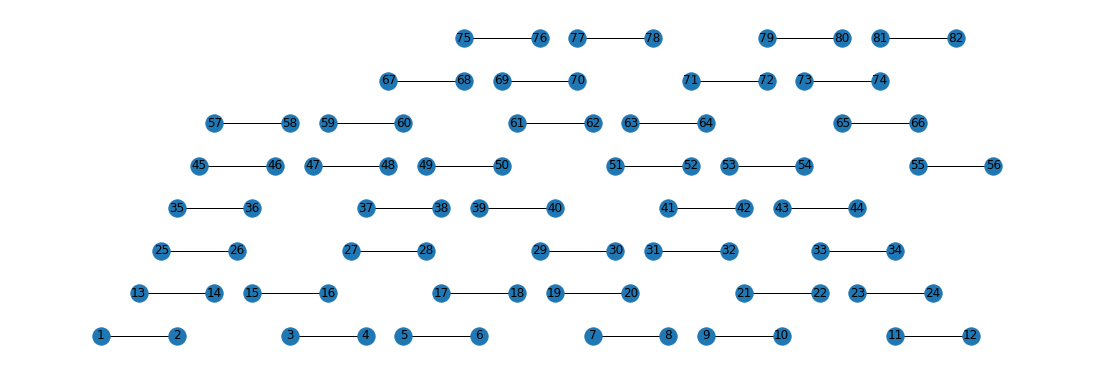

In [262]:
ctr = 1
pos = {}
edges = []
edge_color = []
Trip_graph = nx.Graph()
for bus in new_schd.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        
fig = plt.figure(figsize=(15,5))
Trip_graph.add_nodes_from(pos)
Trip_graph.add_edges_from(edges)
nx.draw(Trip_graph, pos, with_labels = True)
plt.savefig('new_schedule_basic.png')

[['t', 9.25, 9.75], ['s', 9.75, 10.0], ['t', 10.0, 10.5], ['d', 10.5, 10.62], ['c', 10.62, 10.95], ['d', 10.95, 11.07], ['s', 11.07, 11.25], ['t', 11.25, 11.75], ['s', 11.75, 12.0], ['t', 12.0, 12.5], ['d', 12.5, 12.62], ['c', 12.62, 12.97], ['d', 12.97, 13.1], ['s', 13.1, 13.25], ['t', 13.25, 13.75], ['s', 13.75, 14.0], ['t', 14.0, 14.5]]
----------------------------------------------------------------------------------------------------


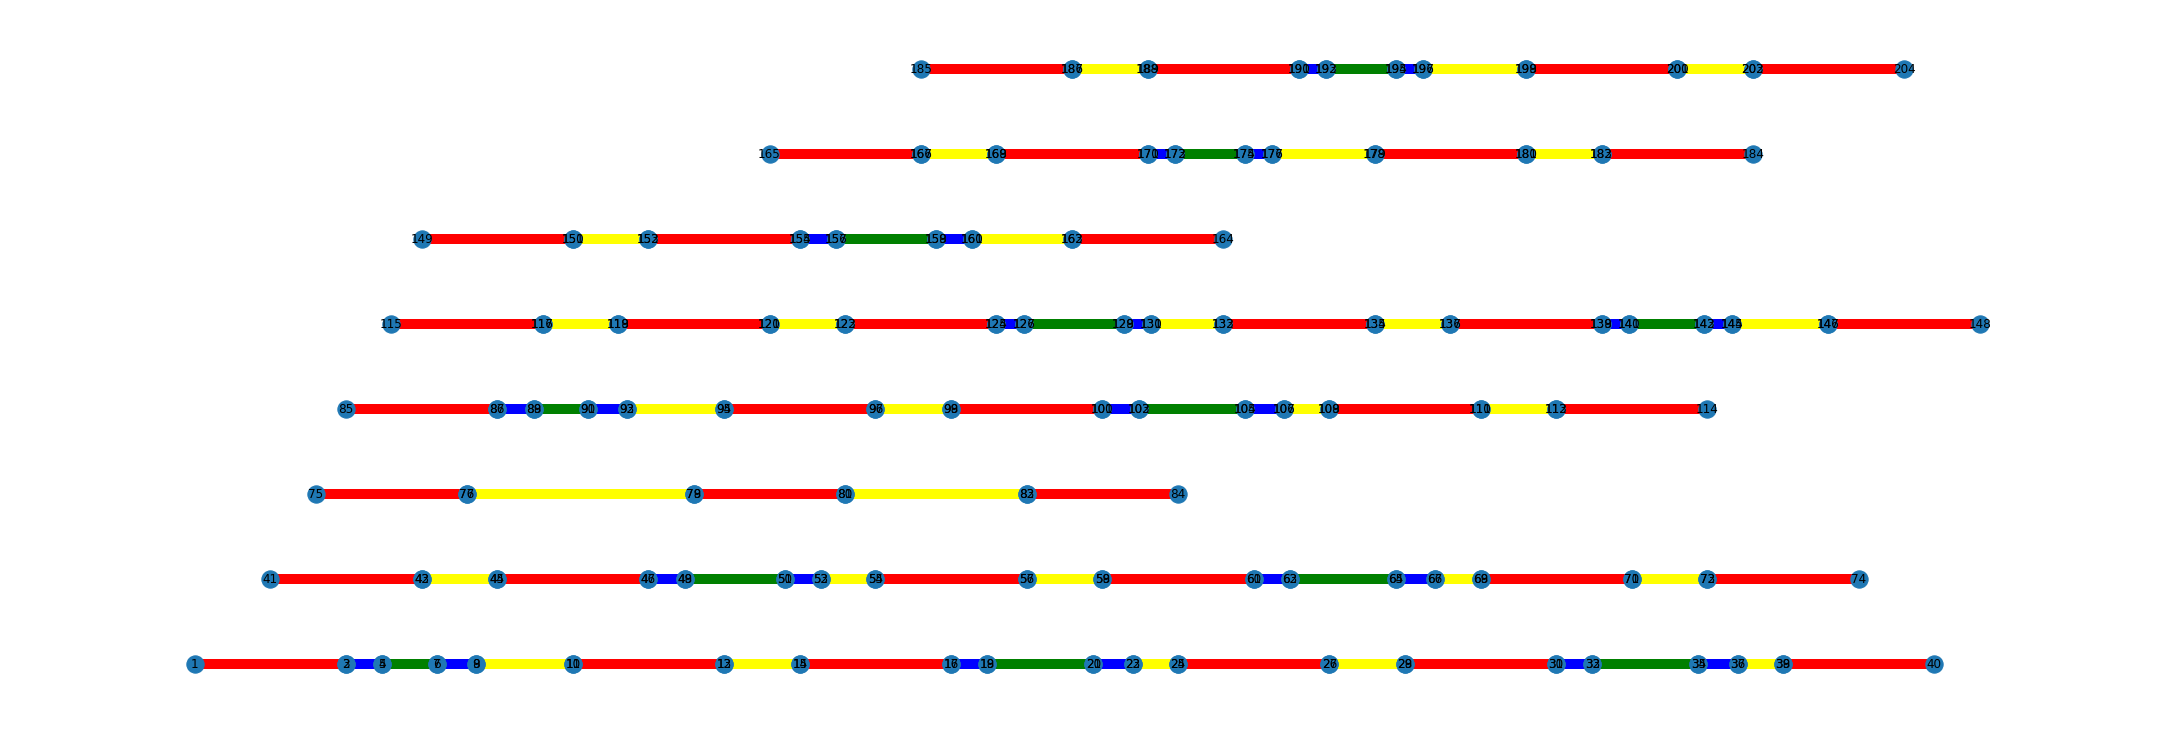

In [314]:
new_schedule = {}
# print(deadhead_trips)
dh_tripz = deepcopy(dht_new)

for bus in new_schd.keys():
    new_sch = []
    for trip in new_schd[bus]:
        new_sch.append(['t', trip[1], trip[2]])
    
    for dh in dh_tripz:
            if dh[0] == bus:
                new_sch.append(['d', dh[3], dh[4]])
    
    new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

for bus in new_schedule.keys():
    charging_trips = []
    for t in range(1,len(new_schedule[bus])):
        if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
            if new_schedule[bus][t-1][0] == 'd' and new_schedule[bus][t-1][0] == new_schedule[bus][t][0]:
                label = 'c'
            else:
                label = 's'
            charging_trips.append([label, new_schedule[bus][t-1][2], new_schedule[bus][t][1]])
#     for trip in charging_trips:
    new_schedule[bus].extend(charging_trips)
    new_schedule[bus].sort(key=lambda y: y[1])

print(new_schedule[2])
print('-'*100)

ctr = 1
pos = {}
edges = []
edge_color = []

new_trip_graph = nx.Graph()
for bus in new_schedule.items():
    for seq in bus[1]:
        pos[ctr] = (seq[1], bus[0])
        ctr += 1
        pos[ctr] = (seq[2], bus[0])
        ctr += 1
        edges.append((ctr-2,ctr-1))
        if seq[0] == 't':
            edge_color.append('red')
        elif seq[0] == 'd':
            edge_color.append('blue')
        elif seq[0] == 'c':
            edge_color.append('green')
        else:
            edge_color.append('yellow')

fig = plt.figure(figsize=(30,10))
new_trip_graph.add_nodes_from(pos)
new_trip_graph.add_edges_from(edges)
nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
plt.savefig('new_schedule.png')

In [272]:
# bus_sch = deepcopy(bus_schedule)
# bus_num = list(bus_sch.keys())
# print(bus_num)
# random.shuffle(bus_num)
# print(bus_num)

# t = random.uniform(op_start, op_end)
# print(t)

# bus_1 = bus_sch[bus_num[0]]
# bus_2 = bus_sch[bus_num[1]]
# print(bus_1, bus_2)

# trip_1, trip_2 = trip_check(bus_1, bus_2, t)
# print(trip_1, '&', trip_2)

In [273]:
# def trip_check(bus_1, bus_2, swap_time):
#     trip_1 = None
#     trip_2 = None
#     temp_1 = None
#     temp_2 = None
#     for t in range(len(bus_1)):
#         if bus_1[t][1] > swap_time:
#             temp_1 =  bus_1[t]
#             break

#     for t in range(len(bus_2)):
#         if bus_2[t][1] > swap_time:
#             trip_2 = bus_2[t]
#             temp_2 = bus_2[t]    
    
#     if temp_1 != None:
#         for trip in trip_copy:
#             if temp_1[0] == trip[0] and temp_1[1] == trip[1]:
#                 trip_1 = trip
#                 break

#     if temp_2 != None:
#         for trip in trip_copy:
#             if temp_2[0] == trip[0] and temp_2[1] == trip[1]:
#                 trip_2 = trip
#                 break
    
#     return (trip_1, trip_2)

# print(t)
# trip_1, trip_2 = trip_check(bus_1, bus_2, t)
# print(trip_1, '&', trip_2)

# # bus_1 = bus_schedule[bus_1]
# # bus_2 = bus_schedule[bus_2]
# # print(bus_1)
# # print(bus_2)

In [274]:
'''
Pick random bus and time; Check if trips from 5 different buses can be inserted there
Rank them based on battery usage
'''

'''
For mergers, try to insert trip during standing time
'''



'\nFor mergers, try to insert trip during standing time\n'

"\n[['t', 9, 9.5], ['d', 9.5, 9.62], ['c', 9.62, 9.8], ['d', 9.8, 9.93], ['s', 9.93, 10.25], \n['t', 10.25, 10.75], ['s', 10.75, 11.0], ['t', 11.0, 11.5]]\n\n['l1', 9, 9.5, 2.59]\n['l2', 10.25, 10.75, 2.24]\n['l1', 11.0, 11.5, 0.83]\n\n[1, 2, 0, 9.5, 9.62, 2.24]\n[1, 0, 2, 9.8, 9.93, 3.65]\n"

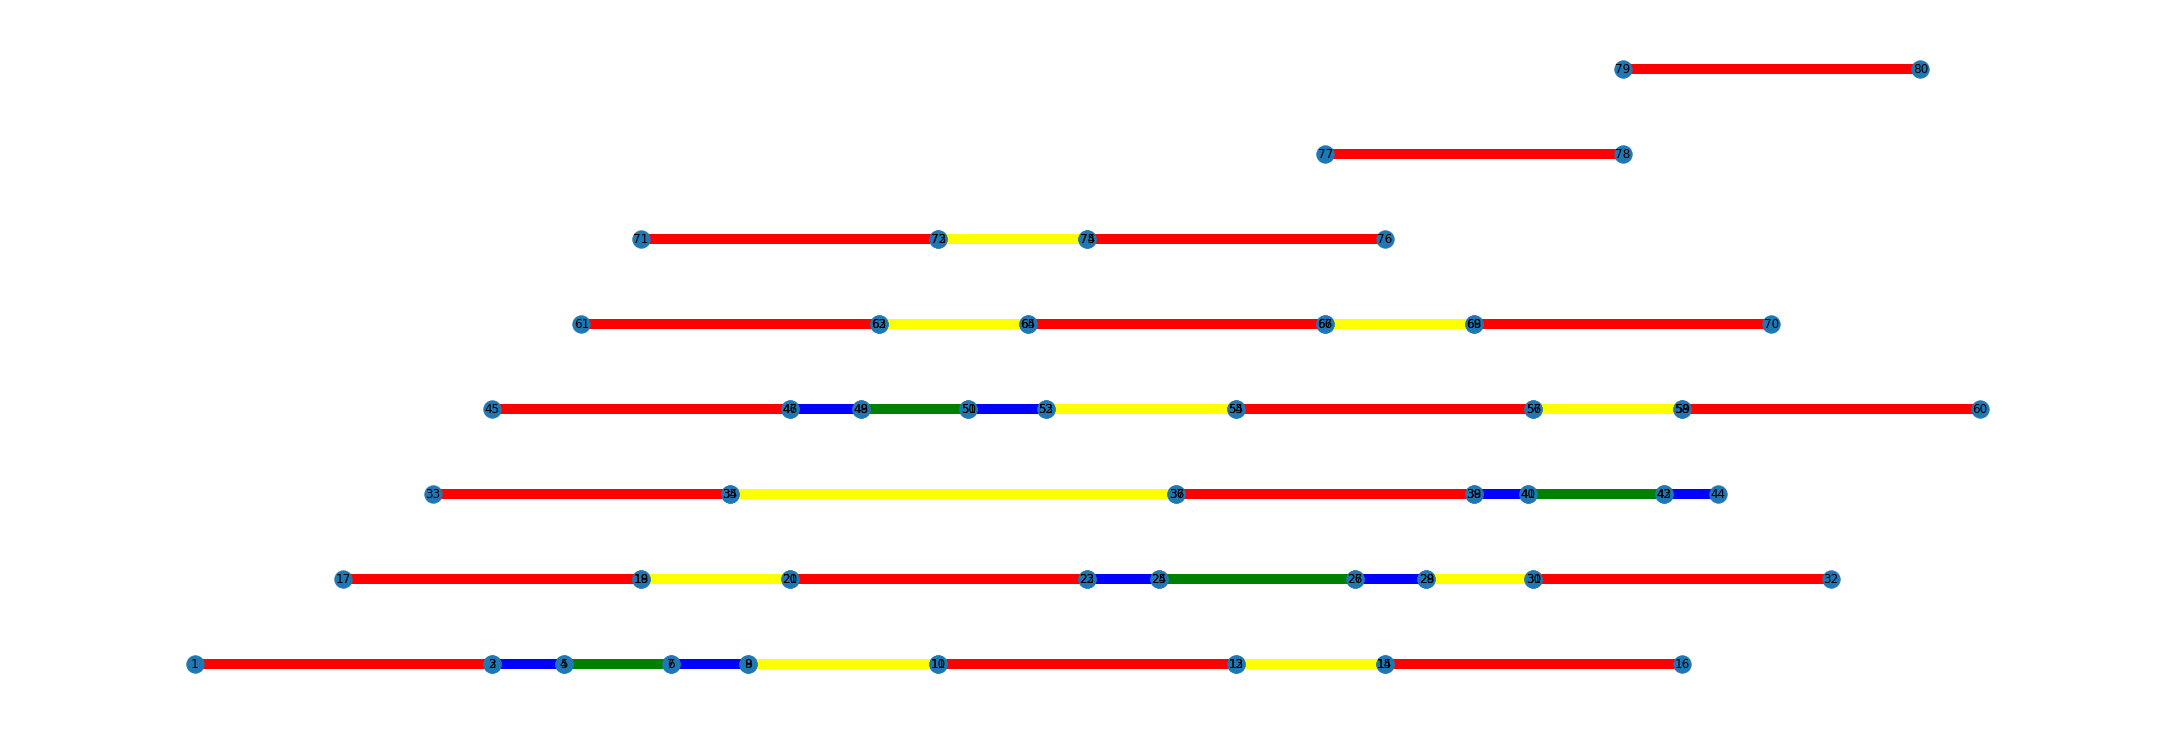

In [58]:
# '''
# REVISED: COMPLETE SCHEDULE
# '''

# new_schedule = {}
# dh_tripz = deepcopy(deadhead_trips)

# for bus in bus_schedule.keys():
#     new_sch = []
#     for trip in bus_schedule[bus]:
#         new_sch.append([('t', trip[0]), trip[1], trip[2], trip[3]])
    
#     for dh in dh_tripz:
#             if dh[0] == bus:
#                 new_sch.append([('d', None), dh[3], dh[4], dh[5]])
    
#     new_schedule[bus] = sorted(new_sch, key=lambda y: y[1])

# # for bus in new_schedule.values():
# #     print(bus)
# #     print('-'*100)
# # trav = 0
# for bus in new_schedule.keys():
#     charging_trips = []
#     for t in range(1,len(new_schedule[bus])):
#         if new_schedule[bus][t][1] != new_schedule[bus][t-1][2]:
#             if new_schedule[bus][t-1][0][0] == 'd' and new_schedule[bus][t-1][0][0] == new_schedule[bus][t][0][0]:
#                 label = 'c'
#                 trav = b_range
#             else:
#                 label = 's'
#                 trav = new_schedule[bus][t-1][3]
#             charging_trips.append([(label, None), new_schedule[bus][t-1][2], new_schedule[bus][t][1], trav])
# #     for trip in charging_trips:
#     new_schedule[bus].extend(charging_trips)
#     new_schedule[bus].sort(key=lambda y: y[1])

# # print(new_schedule[1])
# # print('-'*100)

# ctr = 1
# pos = {}
# edges = []
# edge_color = []

# new_trip_graph = nx.Graph()
# for bus in new_schedule.items():
#     for seq in bus[1]:
#         pos[ctr] = (seq[1], bus[0])
#         ctr += 1
#         pos[ctr] = (seq[2], bus[0])
#         ctr += 1
#         edges.append((ctr-2,ctr-1))
#         if seq[0][0] == 't':
#             edge_color.append('red')
#         elif seq[0][0] == 'd':
#             edge_color.append('blue')
#         elif seq[0][0] == 'c':
#             edge_color.append('green')
#         else:
#             edge_color.append('yellow')

# fig = plt.figure(figsize=(30,10))
# new_trip_graph.add_nodes_from(pos)
# new_trip_graph.add_edges_from(edges)
# nx.draw(new_trip_graph, pos, with_labels = True, edge_color = edge_color, width = 10.0)
# plt.savefig('schedule.png')

# '''
# [['t', 9, 9.5], ['d', 9.5, 9.62], ['c', 9.62, 9.8], ['d', 9.8, 9.93], ['s', 9.93, 10.25], 
# ['t', 10.25, 10.75], ['s', 10.75, 11.0], ['t', 11.0, 11.5]]

# ['l1', 9, 9.5, 2.59]
# ['l2', 10.25, 10.75, 2.24]
# ['l1', 11.0, 11.5, 0.83]

# [1, 2, 0, 9.5, 9.62, 2.24]
# [1, 0, 2, 9.8, 9.93, 3.65]
# '''

In [275]:
# '''
# TRY SWAP, THEN MERGE
# '''

# def stand_times(bus_1):
    
#     stand_times = []
#     for trip in bus_1:
#         if trip[0][0] == 's':
#             stand_times.append([trip[1], round(trip[2]-trip[1], 2)])
    
#     if stand_times == []:
#         return None
#     else:
#         stand_times.sort(key = lambda tup: tup[-1])
#     return stand_times
            
# def insert_trip(bus_1, st_times):
# #     ctr = 0
# #     print(bus_1)
# #     print('-'*20)
#     for bus in bus_sch.values():
# #         print(bus)
#         if bus == bus_1:
#             continue
#         else:
#             for trip in bus:
                
# #             ctr += 1
# #     return ctr

# bus_sch = deepcopy(new_schedule)
# bus_ids = list(bus_sch.keys())
# # random.shuffle(bus_ids)
# bus_num = bus_ids[2]#[0]

# print(bus_ids)
# print('-'*20)
# print(bus_num)
# print('-'*20)

# bus_1 = bus_sch[bus_num]
# print(bus_1)
# print('-'*20)

# st = stand_times(bus_1)
# print(st)
# print('-'*20)

# print(insert_trip(bus_1, st))
# # swap_time = round(random.uniform(op_start, op_end), 2)
# # print(swap_time)
# # print('-'*20)

# # trip_check(bus_1, swap_time)

In [86]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# df = pd.DataFrame(bus_schedule)
# df

# for bus in bus_schedule.items():
#     for trip in bus:
#         print(trip)
#     print('-'*20)
    
# # Start of run time
# proj_start = df.Start.min()
# # Bus trip duration
# # df['start_num'] = (df.Start-proj_start).dt.days
# # # number of days from project start to end of tasks
# # df['end_num'] = (df.End-proj_start).dt.days
# # # days between start and end of each task
# # df['days_start_to_end'] = df.end_num - df.start_num

# fig, ax = plt.subplots(1, figsize=(16,6))
# ax.barh(df.Task, df.days_start_to_end, left=df.start_num)
# plt.show()

In [32]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch
# from pandas import Timestamp

# ##### DATA #####
# data = {'Task': {0: 'TSK M',
#                  1: 'TSK N',
#                  2: 'TSK L',
#                  3: 'TSK K',
#                  4: 'TSK J',
#                  5: 'TSK H',
#                  6: 'TSK I',
#                  7: 'TSK G',
#                  8: 'TSK F',
#                  9: 'TSK E',
#                  10: 'TSK D',
#                  11: 'TSK C',
#                  12: 'TSK B',
#                  13: 'TSK A'},

#  'Department': {0: 'IT',
#                 1: 'MKT',
#                 2: 'ENG',
#                 3: 'PROD',
#                 4: 'PROD',
#                 5: 'FIN',
#                 6: 'MKT',
#                 7: 'FIN',
#                 8: 'MKT',
#                 9: 'ENG',
#                 10: 'FIN',
#                 11: 'IT',
#                 12: 'MKT',
#                 13: 'MKT'},
 
#  'Start': {0: Timestamp('2022-03-17 00:00:00'),
#            1: Timestamp('2022-03-17 00:00:00'),
#            2: Timestamp('2022-03-10 00:00:00'),
#            3: Timestamp('2022-03-09 00:00:00'),
#            4: Timestamp('2022-03-04 00:00:00'),
#            5: Timestamp('2022-02-28 00:00:00'),
#            6: Timestamp('2022-02-28 00:00:00'),
#            7: Timestamp('2022-02-27 00:00:00'),
#            8: Timestamp('2022-02-26 00:00:00'),
#            9: Timestamp('2022-02-23 00:00:00'),
#            10: Timestamp('2022-02-22 00:00:00'),
#            11: Timestamp('2022-02-21 00:00:00'),
#            12: Timestamp('2022-02-19 00:00:00'),
#            13: Timestamp('2022-02-15 00:00:00')},
 
#  'End': {0: Timestamp('2022-03-20 00:00:00'),
#          1: Timestamp('2022-03-19 00:00:00'),
#          2: Timestamp('2022-03-13 00:00:00'),
#          3: Timestamp('2022-03-13 00:00:00'),
#          4: Timestamp('2022-03-17 00:00:00'),
#          5: Timestamp('2022-03-02 00:00:00'),
#          6: Timestamp('2022-03-05 00:00:00'),
#          7: Timestamp('2022-03-03 00:00:00'),
#          8: Timestamp('2022-02-27 00:00:00'),
#          9: Timestamp('2022-03-09 00:00:00'),
#          10: Timestamp('2022-03-01 00:00:00'),
#          11: Timestamp('2022-03-03 00:00:00'),
#          12: Timestamp('2022-02-24 00:00:00'),
#          13: Timestamp('2022-02-20 00:00:00')},
 
#  'Completion': {0: 0.0,
#                 1: 0.0,
#                 2: 0.0,
#                 3: 0.0,
#                 4: 0.0,
#                 5: 1.0,
#                 6: 0.4,
#                 7: 0.7,
#                 8: 1.0,
#                 9: 0.5,
#                 10: 1.0,
#                 11: 0.9,
#                 12: 1.0,
#                 13: 1.0}}


# ##### DATA PREP ##### 
# df = pd.DataFrame(data)

# # project start date
# proj_start = df.Start.min()

# # number of days from project start to task start
# df['start_num'] = (df.Start-proj_start).dt.days

# # number of days from project start to end of tasks
# df['end_num'] = (df.End-proj_start).dt.days

# # days between start and end of each task
# df['days_start_to_end'] = df.end_num - df.start_num

# # days between start and current progression of each task
# df['current_num'] = (df.days_start_to_end * df.Completion)

# # create a column with the color for each department
# def color(row):
#     c_dict = {'MKT':'#E64646', 'FIN':'#E69646', 'ENG':'#34D05C', 'PROD':'#34D0C3', 'IT':'#3475D0'}
#     return c_dict[row['Department']]

# df['color'] = df.apply(color, axis=1)

# ##### PLOT #####
# fig, (ax, ax1) = plt.subplots(2, figsize=(16,6), gridspec_kw={'height_ratios':[6, 1]}, facecolor='#36454F')
# ax.set_facecolor('#36454F')
# ax1.set_facecolor('#36454F')
# # bars
# ax.barh(df.Task, df.current_num, left=df.start_num, color=df.color)
# ax.barh(df.Task, df.days_start_to_end, left=df.start_num, color=df.color, alpha=0.5)

# for idx, row in df.iterrows():
#     ax.text(row.end_num+0.1, idx, f"{int(row.Completion*100)}%", va='center', alpha=0.8, color='w')
#     ax.text(row.start_num-0.1, idx, row.Task, va='center', ha='right', alpha=0.8, color='w')


# # grid lines
# ax.set_axisbelow(True)
# ax.xaxis.grid(color='k', linestyle='dashed', alpha=0.4, which='both')

# # ticks
# xticks = np.arange(0, df.end_num.max()+1, 3)
# xticks_labels = pd.date_range(proj_start, end=df.End.max()).strftime("%m/%d")
# xticks_minor = np.arange(0, df.end_num.max()+1, 1)
# ax.set_xticks(xticks)
# ax.set_xticks(xticks_minor, minor=True)
# ax.set_xticklabels(xticks_labels[::3], color='w')
# ax.set_yticks([])

# plt.setp([ax.get_xticklines()], color='w')

# # align x axis
# ax.set_xlim(0, df.end_num.max())

# # remove spines
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['left'].set_position(('outward', 10))
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_color('w')


# plt.suptitle('PROJECT XYZ', color='w')

# ##### LEGENDS #####
# legend_elements = [Patch(facecolor='#E64646', label='Marketing'),
#                    Patch(facecolor='#E69646', label='Finance'),
#                    Patch(facecolor='#34D05C', label='Engineering'),
#                    Patch(facecolor='#34D0C3', label='Production'),
#                    Patch(facecolor='#3475D0', label='IT')]

# legend = ax1.legend(handles=legend_elements, loc='upper center', ncol=5, frameon=False)
# plt.setp(legend.get_texts(), color='w')

# # clean second axis
# ax1.spines['right'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
# ax1.set_xticks([])
# ax1.set_yticks([])

# # Get "Today" value from sys date/ date.today()
# #from datetime import date
# #today = pd.Timestamp(date.today())
# #today = today - proj_start

# # Get "Today" value from custom timestamp
# today = Timestamp('2022-03-02 00:00:00') 
# today = today - proj_start

# # plot line for today
# ax.axvline(today.days, color='w', lw=1, alpha=0.7)
# ax.text(today.days, len(df)+0.5, 'Today', ha='center', color='w')

# plt.savefig('gantt.png', facecolor='#36454F')